In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib as mpl
import datetime
from sklearn.metrics.pairwise import euclidean_distances
from tqdm.auto import tqdm
from pandas.tseries.offsets import MonthEnd
from  sklearn import decomposition
from sklearn.cluster import AgglomerativeClustering
#sys.path.append("/mnt/d/PHD/ISPRA_20152017_Analysis/modules/")
from plotting import * 
from  matplotlib import colormaps as cmaps  
from scipy import stats 
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib as mpl
import datetime
from pandas.tseries.offsets import MonthEnd
_HOME_ = "/mnt/d"
import modify_dataset
from  matplotlib import colormaps as cmaps 
import json
from sklearn import metrics
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import HDBSCAN
from sklearn.cluster import SpectralClustering
from itertools import combinations
from numba import njit, prange

/home/alberto/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Basics variables and parameters

In [2]:
phyto_abundances = pd.read_csv(_HOME_ + "/PHD/MSFD/Data/Modulo1/phyto_abund_modified.csv", index_col=0)
phyto_abundances.loc[:, "Date"] = pd.to_datetime(phyto_abundances["Date"])

In [3]:
with open(_HOME_ + "/PHD/ISPRA_20152017_Analysis/params.json") as file: 
    params = json.load(file)
best_path = params["best_path"]
best_path_sard = params["best_path_sard"]
ordered_regions = params["ordered_regions"]
seasons = params["seasons"]
sorted_season = params["sorted_season"]
sea_index = params["sea_index"]
ordered_id = params["ordered_id"]
sea_index_array = np.array(list(sea_index.values()))
del params

In [4]:
phyto_abund_simplified = modify_dataset.make_simplified_dataset(phyto_abundances, 0.7)
phyto_abund_simplified = modify_dataset.add_season_column(phyto_abund_simplified, seasons)
phyto_abund_simplified = modify_dataset.add_coast_dist_column(phyto_abund_simplified)
phyto_abund_simplified["Date"] = pd.to_datetime(phyto_abund_simplified["Date"]) + MonthEnd(0)
phyto_abund_simplified["Region"] = pd.Categorical(phyto_abund_simplified["Region"], categories = ordered_regions, ordered = True)

In [5]:
taxonomic_tree = pd.read_excel(_HOME_ + "/PHD/ISPRA_20152017_Analysis/Phyto_taxonomic_tree.xlsx")
taxonomic_tree.drop_duplicates(inplace=True)
phyto_abund_simplified = phyto_abund_simplified.merge(taxonomic_tree.loc[:,["ScientificName", "Genus", "Class"]], how = "left", left_on="Taxon", right_on="ScientificName")
phyto_abund_simplified["Class"] = phyto_abund_simplified["Class"].astype(str)

In [6]:
phyto_abund_simplified = modify_dataset.add_det_level_column(phyto_abund_simplified)

In [7]:
phyto_abund_simplified = phyto_abund_simplified.loc[:,
                                                    ["Region", "id", "Longitude", "Latitude", "Closest_coast", "Coast_dist", "Date", "Season_year", "Season", "Sample_depth", "Class", "Genus", "Det_level", "Taxon", "Num_cell_l", "file_name"]
                                                    ]

In [8]:
transects_info = pd.read_csv("/mnt/d/PHD/ISPRA_20152017_Analysis/transects_info.csv")
transects_info["Transect"] = transects_info["Transect"].str.upper()
phyto_abund_simplified = phyto_abund_simplified.merge(transects_info, how = "left", on = "id")

In [9]:
del transects_info, taxonomic_tree, phyto_abundances

In [10]:
higher_than_class = ['Other phytoplankton', "Haptophyta", "Noctilucea", "Non flagellates"]
sites_species = phyto_abund_simplified.set_index(["id", "Date"]).loc[:, ["Taxon", "Num_cell_l"]].query("Taxon not in @higher_than_class").pivot_table(index = ["id", "Date"], columns="Taxon", values = "Num_cell_l", fill_value=0)

In [ ]:
sites_species = pd.read_csv(_HOME_ + "/PHD/ISPRA_20152017_Analysis/site_taxa_matrix.csv", index_col=[0,1])

## Clustering

In [41]:
def build_linkage_matrix(model) -> np.ndarray : 
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    return np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

## Species subset

In [20]:
with open('selected_species.txt', 'r') as file:
    relevant_species = [line.strip() for line in file]
sites_species = sites_species.loc[:, relevant_species]

hellinger transformation

In [42]:
abund_hellinger = sites_species.apply(lambda x: np.sqrt(x / sum(x)), axis = 1)
X = abund_hellinger.to_numpy()
X_transformed = X

PCA decomposition

In [22]:
pca = decomposition.PCA()
pca.fit(X)
cum_variance = np.cumsum(pca.explained_variance_ratio_) / np.sum(pca.explained_variance_ratio_)
X_transformed = pca.transform(X)[:, :150]

testing various methods

In [22]:
silhouette_scores = {}
calisnki_scores = {}
davies_scores = {}

In [23]:
method_labels = {}

some parameters

In [25]:
min_clusts = 3
max_clusts = 20

single linkage

In [122]:
single_linkage_clustering = AgglomerativeClustering(n_clusters = None, metric = "euclidean", linkage = "single", compute_distances = True, compute_full_tree=True, distance_threshold=0.0)
linkage_clusters = single_linkage_clustering.fit(X_transformed)
linkage_matrix = build_linkage_matrix(linkage_clusters)

In [123]:
method = "single"
n_clusters = np.arange(min_clusts,max_clusts,1)
silhouette = np.empty(n_clusters.size)
calisnki = np.empty(n_clusters.size)
davies = np.empty(n_clusters.size)
single_link_labels = np.empty((n_clusters.size, X_transformed.shape[0]))
for i, n in enumerate(n_clusters):
    single_link_labels[i,:] = fcluster(linkage_matrix, t = n, criterion = "maxclust")
    silhouette[i] = metrics.silhouette_score(X_transformed, single_link_labels[i,:])
    calisnki[i] = metrics.calinski_harabasz_score(X_transformed, single_link_labels[i,:])
    davies[i] = metrics.davies_bouldin_score(X_transformed, single_link_labels[i,:])
silhouette_scores[method] = silhouette
calisnki_scores[method] = calisnki
davies_scores[method] = davies
method_labels[method] = single_link_labels

In [124]:
del single_linkage_clustering, linkage_clusters, linkage_matrix

complete

In [125]:
method = "complete"
n_clusters = np.arange(min_clusts,max_clusts,1)
silhouette = np.empty(n_clusters.size)
calisnki = np.empty(n_clusters.size)
davies = np.empty(n_clusters.size)
complete_link_lables = np.empty((n_clusters.size, X_transformed.shape[0]))
for i, n in enumerate(n_clusters):
    complete_linkage_clustering = AgglomerativeClustering(n_clusters = n, metric = "euclidean", linkage = method, compute_distances = True, compute_full_tree=True)
    linkage_clusters = complete_linkage_clustering.fit(X_transformed)
    complete_link_lables[i,:] = linkage_clusters.labels_
    silhouette[i] = metrics.silhouette_score(X_transformed, complete_link_lables[i,:])
    calisnki[i] = metrics.calinski_harabasz_score(X_transformed, complete_link_lables[i,:])
    davies[i] = metrics.davies_bouldin_score(X_transformed, complete_link_lables[i,:])

silhouette_scores[method] = silhouette
calisnki_scores[method] = calisnki
davies_scores[method] = davies
method_labels[method] = complete_link_lables

In [126]:
del complete_linkage_clustering, linkage_clusters

ward

In [127]:
ward_clustering = AgglomerativeClustering(n_clusters = None, metric = "euclidean", linkage = "ward", compute_distances = True, compute_full_tree=True, distance_threshold=0.0)
ward_clusters = ward_clustering.fit(X_transformed)
linkage_matrix = build_linkage_matrix(ward_clusters)

In [128]:
method = "ward"
n_clusters = np.arange(min_clusts,max_clusts,1)
silhouette = np.empty(n_clusters.size)
calisnki = np.empty(n_clusters.size)
davies = np.empty(n_clusters.size)
ward_labels = np.empty((n_clusters.size, X_transformed.shape[0]))
for i, n in enumerate(n_clusters):
    ward_labels[i,:] = fcluster(linkage_matrix, t = n, criterion = "maxclust")
    silhouette[i] = metrics.silhouette_score(X_transformed, ward_labels[i,:])
    calisnki[i] = metrics.calinski_harabasz_score(X_transformed, ward_labels[i,:])
    davies[i] = metrics.davies_bouldin_score(X_transformed, ward_labels[i,:])

silhouette_scores[method] = silhouette
calisnki_scores[method] = calisnki
davies_scores[method] = davies
method_labels[method] = ward_labels

hdbscan

In [51]:
method = "HDBSCAN"
min_cluster_sizes = np.arange(3, 50, 1)
hdb_labels = np.empty((min_cluster_sizes.size, X_transformed.shape[0]))
for i, min_cluster_size in tqdm(enumerate(min_cluster_sizes)): 
    hdb = HDBSCAN(min_cluster_size=min_cluster_size, metric="euclidean")
    hdb_labels[i,:] = hdb.fit_predict(X_transformed)
    if np.all(np.unique(hdb_labels[i,:]) == -1): 
        break
n_clusters_hdb = np.empty(hdb_labels.shape[0])
silhouette = np.empty(hdb_labels.shape[0])
calisnki = np.empty(hdb_labels.shape[0])
davies = np.empty(hdb_labels.shape[0])
for i in range(hdb_labels.shape[0]): 
    n_clusters_hdb[i] = len(np.unique(hdb_labels[i,:]))
    silhouette[i] = metrics.silhouette_score(X_transformed, hdb_labels[i,:])
    calisnki[i] = metrics.calinski_harabasz_score(X_transformed, hdb_labels[i,:])
    davies[i] = metrics.davies_bouldin_score(X_transformed, hdb_labels[i,:])
silhouette_scores[method] = silhouette
calisnki_scores[method] = calisnki
davies_scores[method] = davies

38it [05:21,  8.45s/it]


spectral

In [129]:
eco_matrix = sites_species.to_numpy()
D_c = np.diag(np.sum(eco_matrix, axis = 0))
#compute diagonal inverse of D_c 
inv = np.diag(1 / np.diag(D_c))
similarity = eco_matrix @ inv @ eco_matrix.T

In [135]:
method = "Spectral_corr"

n_clusters = np.arange(min_clusts,max_clusts,1)
silhouette = np.empty(n_clusters.size)
calisnki = np.empty(n_clusters.size)
davies = np.empty(n_clusters.size)
spectral_labels = np.empty((n_clusters.size, eco_matrix.shape[0]))

for i, n in enumerate(n_clusters):
    spectral_clustering = SpectralClustering(n_clusters = n, affinity = "precomputed", assign_labels="cluster_qr")
    spectral_labels[i,:] = spectral_clustering.fit_predict(similarity)
    silhouette[i] = metrics.silhouette_score(eco_matrix, spectral_labels[i,:])
    calisnki[i] = metrics.calinski_harabasz_score(eco_matrix, spectral_labels[i,:])
    davies[i] = metrics.davies_bouldin_score(eco_matrix, spectral_labels[i,:])

silhouette_scores[method] = silhouette
calisnki_scores[method] = calisnki
davies_scores[method] = davies
method_labels[method] = spectral_labels

KeyboardInterrupt: 

In [131]:
hell_dist = euclidean_distances(X_transformed)

In [133]:
method = "Spectral_dist"

n_clusters = np.arange(min_clusts,max_clusts,1)
silhouette = np.empty(n_clusters.size)
calisnki = np.empty(n_clusters.size)
davies = np.empty(n_clusters.size)
spectral_labels = np.empty((n_clusters.size, eco_matrix.shape[0]))
hell_dist = euclidean_distances(X_transformed)
delta_2 = np.var(hell_dist)
similarity = np.exp(-hell_dist**2 / (2 * delta_2))
for i, n in enumerate(n_clusters):
    spectral_clustering = SpectralClustering(n_clusters = n, affinity = "precomputed", assign_labels="cluster_qr")
    spectral_labels[i,:] = spectral_clustering.fit_predict(similarity)
    silhouette[i] = metrics.silhouette_score(X_transformed, spectral_labels[i,:])
    calisnki[i] = metrics.calinski_harabasz_score(X_transformed, spectral_labels[i,:])
    davies[i] = metrics.davies_bouldin_score(X_transformed, spectral_labels[i,:])

silhouette_scores[method] = silhouette
calisnki_scores[method] = calisnki
davies_scores[method] = davies
method_labels[method] = spectral_labels

KeyboardInterrupt: 

### results

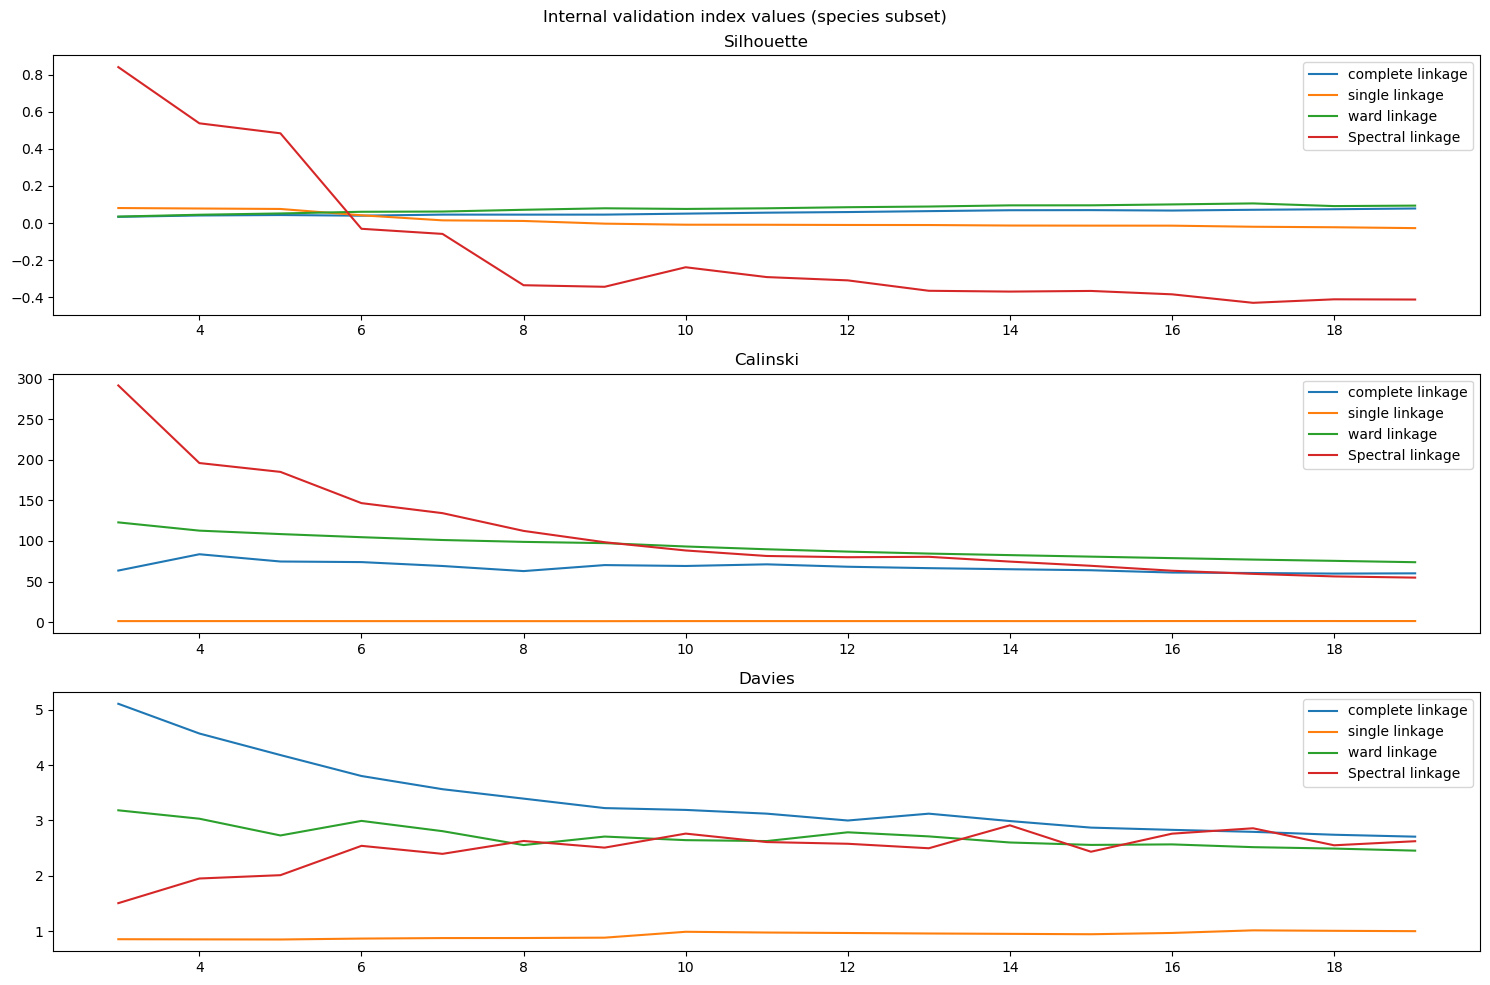

In [105]:
fig, axs = plt.subplots(3,1, figsize = (15,10))
axs = axs.flatten()
for method in ["complete", "single", "ward", "Spectral"]: 
    axs[0].plot(n_clusters, silhouette_scores[method], label = method + " linkage")
    axs[1].plot(n_clusters, calisnki_scores[method], label = method + " linkage")
    axs[2].plot(n_clusters, davies_scores[method], label = method + " linkage")
for (ax, index) in zip(axs, ["Silhouette", "Calinski", "Davies"]): 
    ax.set_title(index)
    ax.legend()
plt.suptitle("Internal validation index values (species subset)")
plt.tight_layout()

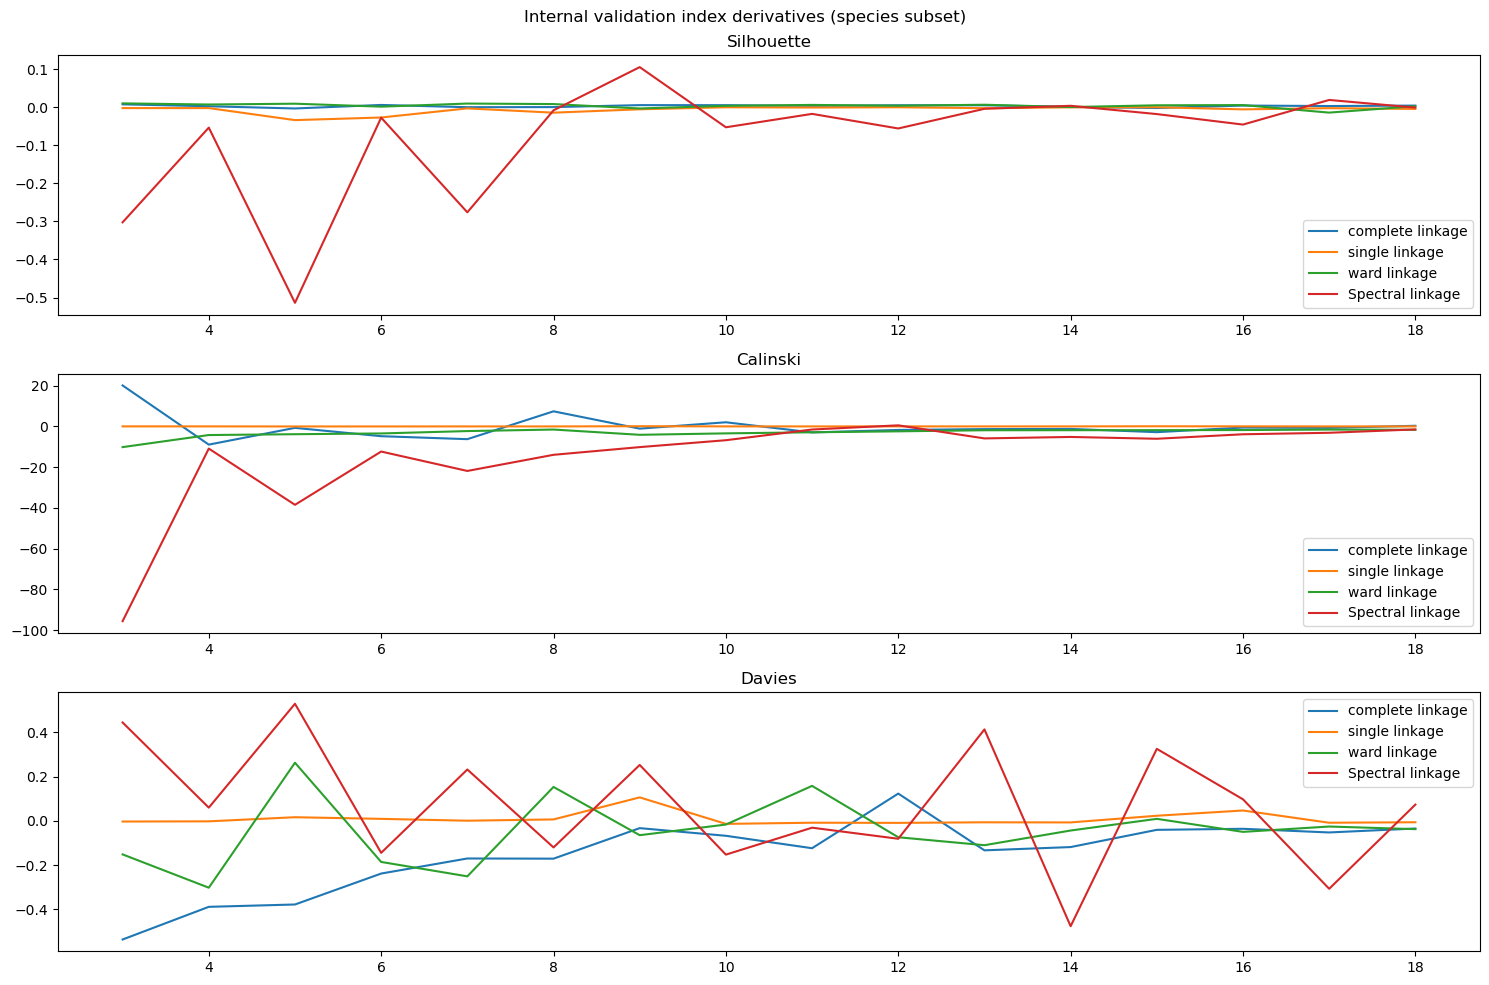

In [106]:
fig, axs = plt.subplots(3,1, figsize = (15,10))
axs = axs.flatten()
for method in ["complete", "single", "ward", "Spectral"]: 
    axs[0].plot(n_clusters[:-1], np.diff(silhouette_scores[method]), label = method + " linkage")
    axs[1].plot(n_clusters[:-1], np.diff(calisnki_scores[method]), label = method + " linkage")
    axs[2].plot(n_clusters[:-1], np.diff(davies_scores[method]), label = method + " linkage")
for (ax, index) in zip(axs, ["Silhouette", "Calinski", "Davies"]): 
    ax.set_title(index)
    ax.legend()
plt.suptitle("Internal validation index derivatives (species subset)")
plt.tight_layout()

similarity by changing n clusters

In [107]:
df_consensus = pd.DataFrame(
    {}
)

In [108]:
for method, labels in method_labels.items(): 
    scores = np.zeros(labels.shape[0]-1)
    for i in range(labels.shape[0]-1): 
        scores[i] = metrics.adjusted_rand_score(labels[i,:], labels[i+1,:])
    df_consensus[method] = scores

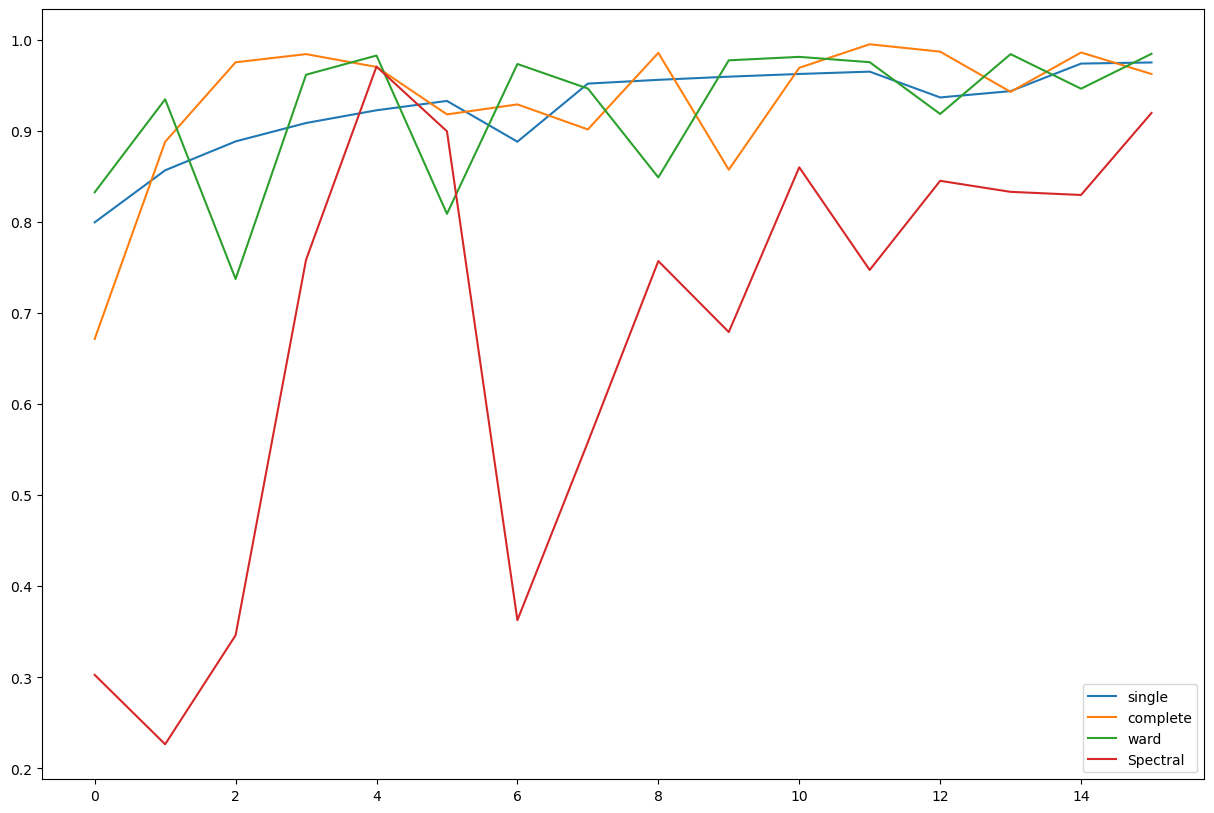

In [109]:
fgi, ax = plt.subplots(1,1, figsize = (15,10))
for column in df_consensus.columns:
    ax.plot(df_consensus[column], label = column)
ax.legend()

In [110]:
values = {}
for method, labels in method_labels.items(): 
    values[method] = []
    for i in range(labels.shape[0]): 
        values[method] += [np.unique(labels[i,:], return_counts = True)[1]]
    values[method] = np.concatenate(values[method])
df_n_cluster_members = pd.DataFrame(
    values,
    index = pd.MultiIndex.from_tuples([(n_clusters, ith) for n_clusters in np.arange(min_clusts, max_clusts, 1) for ith in range(n_clusters)], names = ["N_clusters", "Index"])
)

single
complete
ward
Spectral


In [118]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    display(df_n_cluster_members)

single  complete  ward  Spectral
N_clusters Index                                  
3          0        2217      1232  1335        30
           1           1       296   319      2126
           2           1       691   565        63
4          0        2216       680   172        30
           1           1       296  1163      1787
           2           1       691   319       338
           3           1       552   565        64
5          0        2215       296   172       214
           1           1       229  1163        23
           2           1       691   319        63
           3           1       552   201      1861
           4           1       451   364        58
6          0        2214       229   172       574
           1           1       552   851      1314
           2           1       691   312       160
           3           1       178   319        24
           4           1       451   201        90
           5           1       118   364        57
7          0        2213       691   172       506
           1           1       552   851      1147
           2           1       106   312       152
           3           1       178   319        27
           4           1       451   201        23
           5           1       118   208       313
           6           1       123   156        51
8          0        2212       552   172        38
           1           1       451   851       490
           2           1       106    55      1133
           3           1       178   257       153
           4           1       654   319        27
           5           1       118   201        23
           6           1       123   208       303
           7           1        37   156        52
9          0        2211       451   172        41
           1           1       654   223       158
           2           1       106   628       317
           3           1       178    55      1145
           4           1       159   257       154
           5           1       118   319        28
           6           1       123   201        22
           7           1        37   208       302
           8           1       393   156        52
10         0        2209       654   172        25
           1           2       183   223        68
           2           1       106   628       365
           3           1       178    55       186
           4           1       268   125      1117
           5           1       118   132       168
           6           1       123   319        28
           7           1        37   201        23
           8           1       393   208       187
           9           1       159   156        52
11         0        2208       183   172        24
           1           1       542   223       255
           2           2       106    55        59
           3           1       178   573       285
           4           1       268    55       176
           5           1       118   125      1021
           6           1       123   132       107
           7           1        37   319        27
           8           1       393   201        23
           9           1       159   208       191
           10          1       112   156        51
12         0        2207       542   172        22
           1           1       268   223       245
           2           1       106    55        54
           3           2       178   357       270
           4           1        74   216       268
           5           1       109    55       164
           6           1       123   125       877
           7           1        37   132       105
           8           1       393   319        24
           9           1       159   201        21
           10          1       112   208       120
           11          1       118   156        49
13         0        2206       239   172        21
           1           1       268   223

In [88]:
df_consensus = pd.DataFrame(
    {},
    columns = pd.MultiIndex(levels = [[], []], codes = [[], []], names = ["Index", "Methods"])
)
for method_1, method_2 in combinations(method_labels.keys(), 2): 
    labels_1 = method_labels[method_1]
    labels_2 = method_labels[method_2]
    scores_1 = np.zeros(labels_1.shape[0])
    scores_2 = np.zeros(labels_2.shape[0])
    for i in range(labels_1.shape[0]): 
        scores_1[i] = metrics.adjusted_rand_score(labels_1[i,:], labels_2[i,:])
        scores_2[i] = metrics.normalized_mutual_info_score(labels_1[i,:], labels_2[i,:])
    df_consensus[("ARI", method_1 + "_" + method_2)] = scores_1
    df_consensus[("NMI", method_1 + "_" + method_2)] = scores_2
df_consensus = df_consensus.loc[:, ["ARI", "NMI"]]

## with all species

In [68]:
sites_species = phyto_abund_simplified.set_index(["id", "Date"]).loc[:, ["Taxon", "Num_cell_l"]].query("Taxon not in @higher_than_class").pivot_table(index = ["id", "Date"], columns="Taxon", values = "Num_cell_l", fill_value=0)

hellinger transformation

In [44]:
abund_hellinger = sites_species.apply(lambda x: np.sqrt(x / sum(x)), axis = 1)
X = abund_hellinger.to_numpy()
X_transformed = X

In [70]:
silhouette_scores = {}
calisnki_scores = {}
davies_scores = {}
method_labels = {}

some parameters

In [73]:

min_clusts = 3
max_clusts = 20

single linkage

In [74]:
single_linkage_clustering = AgglomerativeClustering(n_clusters = None, metric = "euclidean", linkage = "single", compute_distances = True, compute_full_tree=True, distance_threshold=0.0)
linkage_clusters = single_linkage_clustering.fit(X_transformed)
linkage_matrix = build_linkage_matrix(linkage_clusters)

In [75]:
method = "single"
n_clusters = np.arange(min_clusts,max_clusts,1)
silhouette = np.empty(n_clusters.size)
calisnki = np.empty(n_clusters.size)
davies = np.empty(n_clusters.size)
single_link_labels = np.empty((n_clusters.size, X_transformed.shape[0]))
for i, n in enumerate(n_clusters):
    single_link_labels[i,:] = fcluster(linkage_matrix, t = n, criterion = "maxclust")
    silhouette[i] = metrics.silhouette_score(X_transformed, single_link_labels[i,:])
    calisnki[i] = metrics.calinski_harabasz_score(X_transformed, single_link_labels[i,:])
    davies[i] = metrics.davies_bouldin_score(X_transformed, single_link_labels[i,:])
silhouette_scores[method] = silhouette
calisnki_scores[method] = calisnki
davies_scores[method] = davies
method_labels[method] = single_link_labels
del single_linkage_clustering, linkage_clusters, linkage_matrix

complete

In [76]:
method = "complete"
n_clusters = np.arange(min_clusts,max_clusts,1)
silhouette = np.empty(n_clusters.size)
calisnki = np.empty(n_clusters.size)
davies = np.empty(n_clusters.size)
complete_link_lables = np.empty((n_clusters.size, X_transformed.shape[0]))
for i, n in enumerate(n_clusters):
    complete_linkage_clustering = AgglomerativeClustering(n_clusters = n, metric = "euclidean", linkage = method, compute_distances = True, compute_full_tree=True)
    linkage_clusters = complete_linkage_clustering.fit(X_transformed)
    complete_link_lables[i,:] = linkage_clusters.labels_
    silhouette[i] = metrics.silhouette_score(X_transformed, complete_link_lables[i,:])
    calisnki[i] = metrics.calinski_harabasz_score(X_transformed, complete_link_lables[i,:])
    davies[i] = metrics.davies_bouldin_score(X_transformed, complete_link_lables[i,:])

silhouette_scores[method] = silhouette
calisnki_scores[method] = calisnki
davies_scores[method] = davies
method_labels[method] = complete_link_lables
del complete_linkage_clustering, linkage_clusters

ward

In [77]:
ward_clustering = AgglomerativeClustering(n_clusters = None, metric = "euclidean", linkage = "ward", compute_distances = True, compute_full_tree=True, distance_threshold=0.0)
ward_clusters = ward_clustering.fit(X_transformed)
linkage_matrix = build_linkage_matrix(ward_clusters)
method = "ward"
n_clusters = np.arange(min_clusts,max_clusts,1)
silhouette = np.empty(n_clusters.size)
calisnki = np.empty(n_clusters.size)
davies = np.empty(n_clusters.size)
ward_labels = np.empty((n_clusters.size, X_transformed.shape[0]))
for i, n in enumerate(n_clusters):
    ward_labels[i,:] = fcluster(linkage_matrix, t = n, criterion = "maxclust")
    silhouette[i] = metrics.silhouette_score(X_transformed, ward_labels[i,:])
    calisnki[i] = metrics.calinski_harabasz_score(X_transformed, ward_labels[i,:])
    davies[i] = metrics.davies_bouldin_score(X_transformed, ward_labels[i,:])

silhouette_scores[method] = silhouette
calisnki_scores[method] = calisnki
davies_scores[method] = davies
method_labels[method] = ward_labels

spectral

In [79]:
eco_matrix = sites_species.to_numpy()
D_c = np.diag(np.sum(eco_matrix, axis = 0))
#compute diagonal inverse of D_c 
inv = np.diag(1 / np.diag(D_c))
similarity = eco_matrix @ inv @ eco_matrix.T

In [80]:
method = "Spectral"
n_clusters = np.arange(min_clusts,max_clusts,1)
silhouette = np.empty(n_clusters.size)
calisnki = np.empty(n_clusters.size)
davies = np.empty(n_clusters.size)
spectral_labels = np.empty((n_clusters.size, X_transformed.shape[0]))

for i, n in enumerate(n_clusters):
    spectral_clustering = SpectralClustering(n_clusters = n, affinity = "precomputed", assign_labels="cluster_qr")
    spectral_labels[i,:] = spectral_clustering.fit_predict(similarity)
    silhouette[i] = metrics.silhouette_score(X_transformed, spectral_labels[i,:])
    calisnki[i] = metrics.calinski_harabasz_score(X_transformed, spectral_labels[i,:])
    davies[i] = metrics.davies_bouldin_score(X_transformed, spectral_labels[i,:])

silhouette_scores[method] = silhouette
calisnki_scores[method] = calisnki
davies_scores[method] = davies
method_labels[method] = spectral_labels

### results

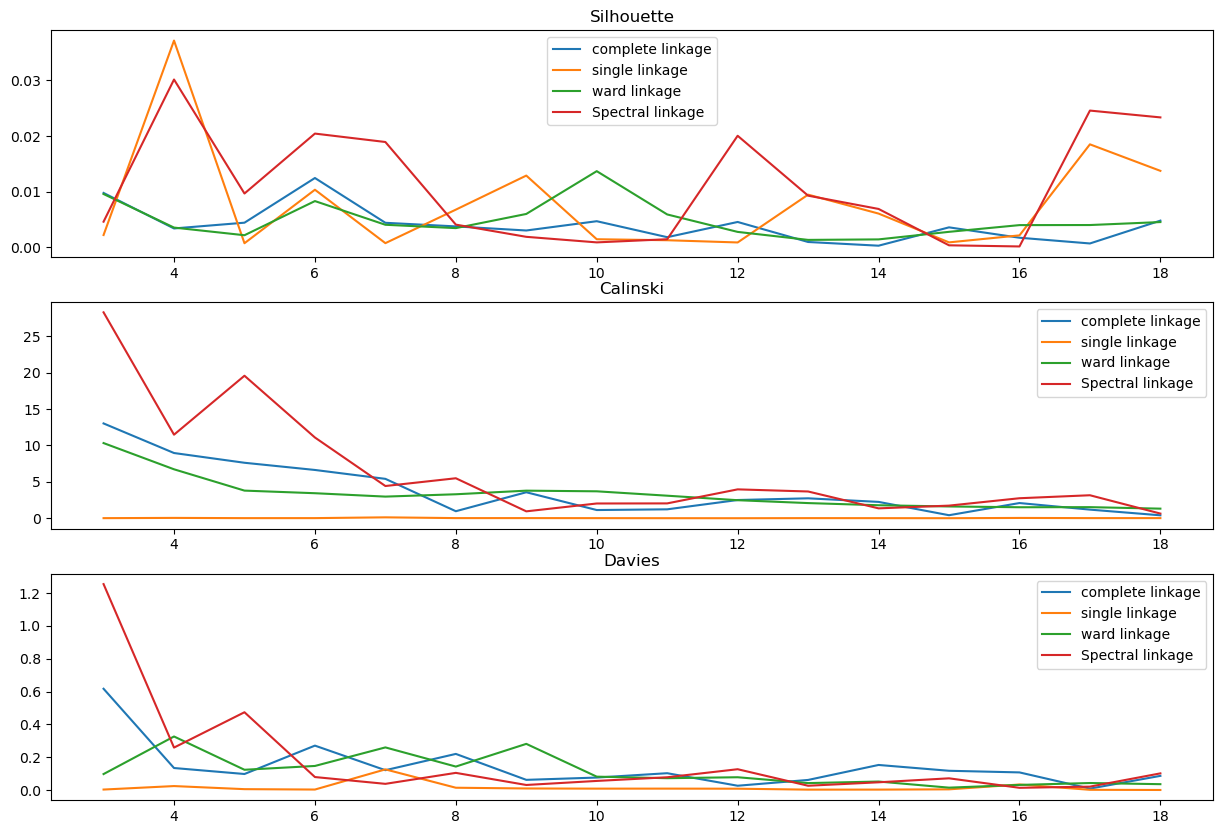

In [81]:
fig, axs = plt.subplots(3,1, figsize = (15,10))
axs = axs.flatten()
for method in ["complete", "single", "ward", "Spectral"]: 
    axs[0].plot(n_clusters[:-1], np.abs(np.diff(silhouette_scores[method])), label = method + " linkage")
    axs[1].plot(n_clusters[:-1], np.abs(np.diff(calisnki_scores[method])), label = method + " linkage")
    axs[2].plot(n_clusters[:-1], np.abs(np.diff(davies_scores[method])), label = method + " linkage")
for (ax, index) in zip(axs, ["Silhouette", "Calinski", "Davies"]): 
    ax.set_title(index)
    ax.legend()

similarity by changing n clusters

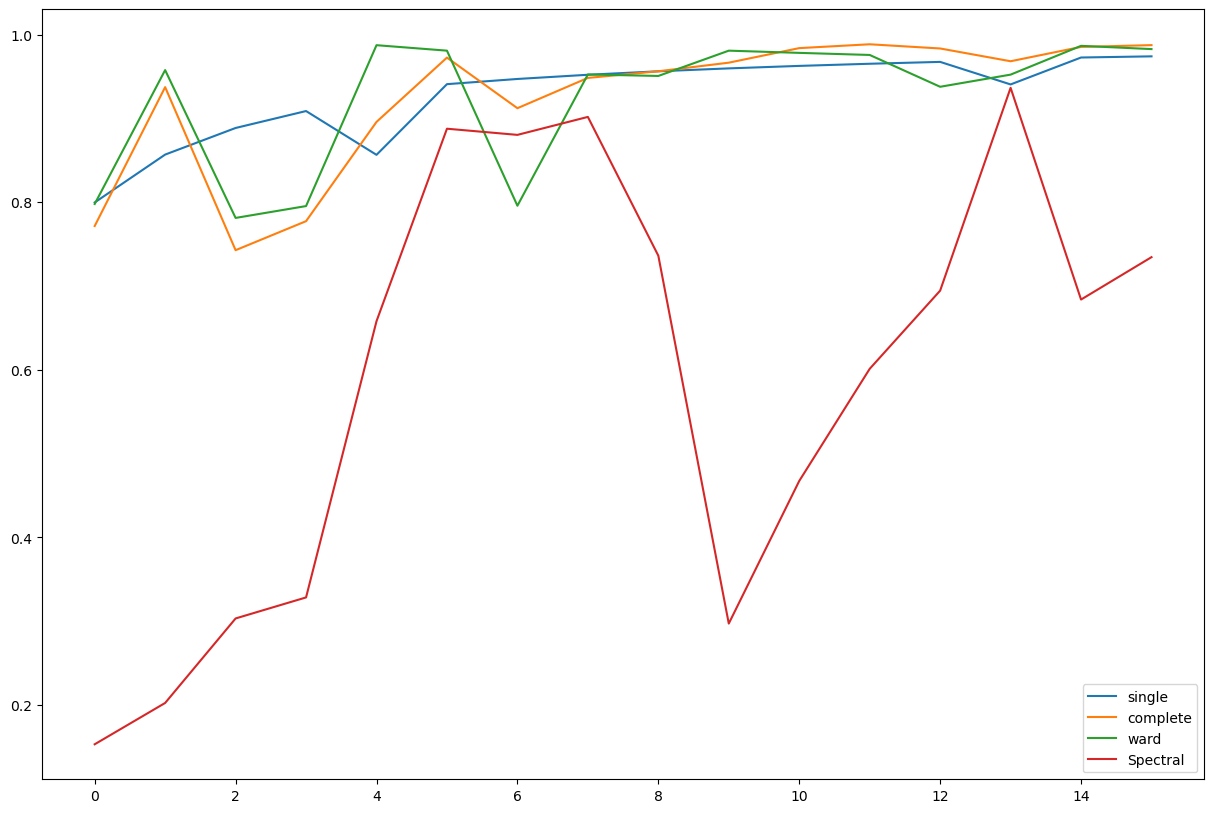

In [82]:
df_consensus = pd.DataFrame(
    {}
)
for method, labels in method_labels.items(): 
    scores = np.zeros(labels.shape[0]-1)
    for i in range(labels.shape[0]-1): 
        scores[i] = metrics.adjusted_rand_score(labels[i,:], labels[i+1,:])
    df_consensus[method] = scores
fgi, ax = plt.subplots(1,1, figsize = (15,10))
for column in df_consensus.columns:
    ax.plot(df_consensus[column], label = column)
ax.legend()

In [48]:
values = {}
for method, labels in method_labels.items(): 
    print(method)
    values[method] = []
    for i in range(labels.shape[0]): 
        values[method] += [np.unique(labels[i,:], return_counts = True)[1]]
    values[method] = np.concatenate(values[method])
df_n_cluster_members = pd.DataFrame(
    values,
    index = pd.MultiIndex.from_tuples([(n_clusters, ith) for n_clusters in np.arange(min_clusts, max_clusts, 1) for ith in range(n_clusters)], names = ["N_clusters", "Index"])
)

single
complete
ward
Spectral


In [49]:
df_n_cluster_members

single  complete  ward  Spectral
N_clusters Index                                  
3          0        2217      1426  1402        28
           1           1       542   377      2128
           2           1       251   440        63
4          0        2216       542   204        31
           1           1      1192  1198      1344
...                  ...       ...   ...       ...
19         14          1        28    64        59
           15          1        70    65        22
           16          1       164    70        20
           17          1       118   147        74
           18          1        44    94        45

[187 rows x 4 columns]

In [83]:
df_consensus = pd.DataFrame(
    {},
    columns = pd.MultiIndex(levels = [[], []], codes = [[], []], names = ["Index", "Methods"])
)
for method_1, method_2 in combinations(method_labels.keys(), 2): 
    labels_1 = method_labels[method_1]
    labels_2 = method_labels[method_2]
    scores_1 = np.zeros(labels_1.shape[0])
    scores_2 = np.zeros(labels_2.shape[0])
    for i in range(labels_1.shape[0]): 
        scores_1[i] = metrics.adjusted_rand_score(labels_1[i,:], labels_2[i,:])
        scores_2[i] = metrics.normalized_mutual_info_score(labels_1[i,:], labels_2[i,:])
    df_consensus[("ARI", method_1 + "_" + method_2)] = scores_1
    df_consensus[("NMI", method_1 + "_" + method_2)] = scores_2
df_consensus = df_consensus.loc[:, ["ARI", "NMI"]]
df_consensus

Index               ARI                                            \
Methods single_complete single_ward single_Spectral complete_ward   
0              0.001691   -0.001113       -0.001709     -0.034771   
1              0.001105   -0.001469       -0.000316      0.105553   
2              0.001107   -0.002116       -0.001840      0.068164   
3              0.000470   -0.002137       -0.003846      0.162826   
4              0.000009   -0.001824       -0.000954      0.282936   
5             -0.000216   -0.002484       -0.002048      0.255320   
6             -0.000485   -0.002885       -0.000721      0.270279   
7             -0.000618   -0.000758       -0.000036      0.314278   
8             -0.000512   -0.001044        0.000268      0.312005   
9             -0.000060   -0.000249       -0.000198      0.336054   
10             0.000861   -0.000370       -0.002515      0.328039   
11             0.000859   -0.000028       -0.000362      0.334428   
12             0.000875   -0.000158        0.000701      0.343839   
13             0.000949   -0.000484        0.001934      0.368901   
14             0.000949   -0.000553        0.002006      0.358197   
15             0.000760   -0.000571        0.000221      0.364701   
16             0.000698   -0.000312        0.001072      0.368577   

Index                                               NMI              \
Methods complete_Spectral ward_Spectral single_complete single_ward   
0                0.079482     -0.044527        0.002881    0.000900   
1                0.103484      0.120785        0.003252    0.001407   
2                0.009327      0.170299        0.004318    0.001677   
3                0.009382      0.115052        0.004739    0.002367   
4                0.045367      0.109823        0.005241    0.003317   
5                0.091035      0.139052        0.006664    0.004283   
6                0.100887      0.131251        0.007064    0.004635   
7                0.123736      0.144356        0.007713    0.007461   
8                0.147125      0.110503        0.008814    0.007880   
9                0.182999      0.164643        0.010467    0.009946   
10               0.101648      0.088183        0.013810    0.010484   
11               0.208759      0.177490        0.014555    0.011793   
12               0.215818      0.207796        0.015338    0.012318   
13               0.243057      0.209898        0.016336    0.012657   
14               0.251658      0.225555        0.018030    0.014384   
15               0.227596      0.186395        0.018367    0.015111   
16               0.258602      0.204927        0.018964    0.016292   

Index                                                                  
Methods single_Spectral complete_ward complete_Spectral ward_Spectral  
0              0.000370      0.085411          0.100610      0.031728  
1              0.002184      0.241331          0.109748      0.275724  
2              0.001897      0.271959          0.139529      0.241726  
3              0.001252      0.320088          0.113937      0.250692  
4              0.003754      0.374511          0.166335      0.310167  
5              0.004746      0.399146          0.213589      0.359016  
6              0.007420      0.440872          0.238548      0.355605  
7              0.008018      0.466515          0.265150      0.342478  
8              0.009214      0.484901          0.290258      0.337686  
9              0.009795      0.508900          0.316620      0.366921  
10             0.009592      0.517467          0.287482      0.348836  
11             0.010992      0.525992          0.345790      0.401359  
12             0.013646      0.540619          0.341968      0.421962  
13             0.016124      0.562409          0.368695      0.446605  
14             0.017774      0.568913          0.376569      0.449113  
15             0.016500      0.580951          0.378482      0.426943  
16             0.017120      0.590728     

## Spectral clustering

In [48]:
spectral_labels = spectal.fit_predict(similarity)

In [ ]:
for n in n_clusters:
    H_clusters = AgglomerativeClustering(n_clusters = 15, metric = "euclidean", linkage = "ward", compute_distances = True)
    hellinger_clusers = H_clusters.fit(X)
    metrics.silhouette_score(X, hellinger_clusers.labels_, metric = "euclidean")
    metrics.calinski_harabasz_score(X, hellinger_clusers.labels_)
    metrics.davies_bouldin_score(X, hellinger_clusers.labels_)

test

In [70]:
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

In [71]:
n_samples = 500
seed = 30
noisy_circles = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed
)

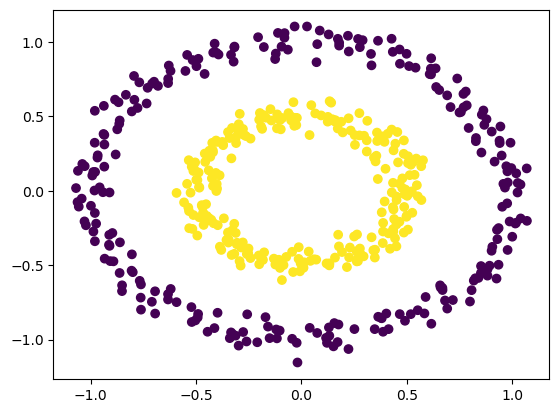

In [74]:
plt.scatter(*noisy_circles[0].T, c = noisy_circles[1])

In [75]:
spectral = cluster.SpectralClustering(
        n_clusters=2,
        eigen_solver="arpack",
        affinity="nearest_neighbors",
        random_state=42,
    )

In [88]:
from sklearn.neighbors import NearestNeighbors

# Fit nearest neighbors
nn = NearestNeighbors(n_neighbors=1)
nn.fit(noisy_circles[0])

# Get the adjacency matrix (in sparse format)
adjacency = nn.kneighbors_graph(noisy_circles[0])

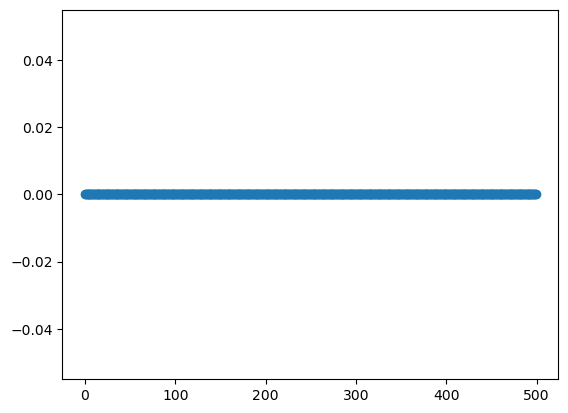

In [89]:
Laplacian = csgraph.laplacian(adjacency.toarray(), normed=True, return_diag=False)
eigenvalues, eigenvectors = np.linalg.eighs(Laplacian)
plt.scatter(np.arange(0, len(eigenvalues)), eigenvalues)

## stability test 

In [11]:
from reval.best_nclust_cv import FindBestClustCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [45]:
X_ts, X_tr = train_test_split(X_transformed, train_size=0.25, random_state = 42)

In [46]:
print(
    X_tr.shape, 
    X_ts.shape
)

(1665, 773) (554, 773)


In [57]:
classifier = KNeighborsClassifier()
clustering = AgglomerativeClustering(metric = "euclidean", linkage = "ward", compute_distances = True, compute_full_tree=True)
findbestclust = FindBestClustCV(nfold=2,
                                nclust_range=list(range(2, 11)),
                                s=classifier,
                                c=clustering,
                                n_jobs = 4,
                                nrand=10)
#metrics, nbest = findbestclust.best_nclust(X_tr, iter_cv=10, strat_vect=y_tr)
#out = findbestclust.evaluate(X_tr, X_ts, nbest)

In [58]:
metrics, nbest = findbestclust.best_nclust(X_tr, iter_cv=10)

KeyboardInterrupt: 

In [49]:
out = findbestclust.evaluate(X_tr, X_ts, nbest)

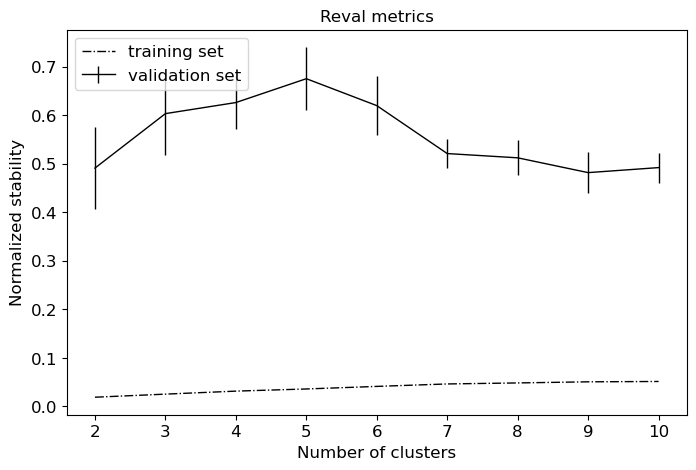

In [51]:
plot_metrics(metrics, title="Reval metrics")

In [12]:
from reval.best_nclust_cv import FindBestClustCV
from sklearn.datasets import make_blobs
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [13]:
data = make_blobs(1000, 2, centers=2, random_state=42)

In [14]:
X_tr, X_ts, y_tr, y_ts = train_test_split(data[0], data[1],
                                          test_size=0.30,
                                          random_state=42,
                                          stratify=data[1])

In [28]:
classifier = KNeighborsClassifier()
clustering = AgglomerativeClustering()
findbestclust = FindBestClustCV(nfold=2,
                                nclust_range=list(range(2, 11)),
                                s=classifier,
                                c=clustering,
                                n_jobs=4,
                                nrand=10)

In [34]:
metrics, nbest = findbestclust.best_nclust(X_tr, iter_cv=10)

In [35]:
out = findbestclust.evaluate(X_tr, X_ts, nbest)

In [36]:
metrics['val'][nbest]

(0.0, (0.0, 0.0))

In [37]:
findbestclust.cv_results_

,ncl,ms_tr,ms_val,tr_labels,val_labels
0,2,0.000000,0.000000,"[0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, ...","[1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ..."
1,3,0.005714,0.272727,"[1, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 2, 2, 1, 2, 1, 2, 0, 1, 0, 2, ..."
2,4,0.014286,0.364716,"[1, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 3, ...","[0, 3, 1, 0, 3, 2, 2, 1, 2, 1, 2, 0, 1, 3, 2, ..."
3,5,0.020000,0.701468,"[0, 0, 4, 4, 1, 4, 4, 1, 2, 4, 4, 1, 1, 4, 3, ...","[1, 3, 4, 1, 3, 2, 2, 0, 2, 0, 2, 1, 0, 3, 2, ..."
4,6,0.020000,0.562376,"[4, 5, 1, 1, 0, 1, 1, 0, 2, 1, 1, 0, 0, 1, 3, ...","[0, 3, 4, 0, 3, 2, 2, 5, 2, 5, 2, 1, 5, 3, 2, ..."
...,...,...,...,...,...
175,6,0.011429,0.298387,"[1, 0, 3, 2, 2, 4, 3, 2, 1, 4, 2, 0, 2, 0, 1, ...","[2, 3, 5, 0, 0, 1, 0, 0, 1, 3, 2, 0, 1, 3, 5, ..."
176,7,0.011429,0.390127,"[0, 1, 3, 2, 2, 4, 3, 2, 0, 4, 2, 6, 2, 1, 0, ...","[2, 6, 5, 1, 1, 0, 1, 1, 0, 3, 2, 1, 0, 3, 5, ..."
177,8,0.017143,0.489891,"[7, 1, 3, 0, 0, 4, 3, 0, 7, 4, 0, 6, 0, 1, 7, ...","[0, 7, 5, 1, 1, 2, 6, 1, 2, 3, 0, 6, 2, 3, 5, ..."
178,9,0.017143,0.525114,"[7, 0, 1, 8, 8, 4, 1, 8, 7, 4, 3, 6, 8, 0, 7, ...","[8, 5, 3, 0, 0, 2, 6, 0, 2, 1, 8, 6, 7, 1, 3, ..."


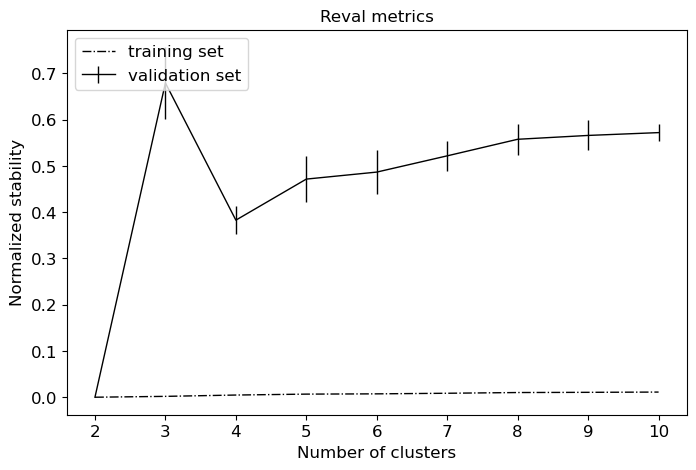

In [38]:
from reval.visualization import plot_metrics
plot_metrics(metrics, title="Reval metrics")

In [39]:
metrics

{'train': {2: (0.0, (0.0, 0.0)),
  3: (0.0018571428571428628, (0.0018571428571428628, 0.0011405325288906252)),
  4: (0.004714285714285704, (0.004714285714285704, 0.0016526534205895409)),
  5: (0.006714285714285712, (0.006714285714285712, 0.0020833910620923065)),
  6: (0.007285714285714279, (0.007285714285714279, 0.002134264662471694)),
  7: (0.008571428571428558, (0.008571428571428558, 0.0021972175511449283)),
  8: (0.010142857142857137, (0.010142857142857137, 0.0024465352089442917)),
  9: (0.010571428571428565, (0.010571428571428565, 0.0027436722155561367)),
  10: (0.011142857142857138, (0.011142857142857138, 0.002704287317306614))},
 'val': {2: (0.0, (0.0, 0.0)),
  3: (0.6795062281992299, (0.6795062281992299, 0.07722112152333328)),
  4: (0.3828579759128409, (0.3828579759128409, 0.030845194022970566)),
  5: (0.47161561343004416, (0.47161561343004416, 0.04950736937020849)),
  6: (0.4867623656326413, (0.4867623656326413, 0.04733800352618458)),
  7: (0.5218826962545473, (0.52188269625454

# other stuff

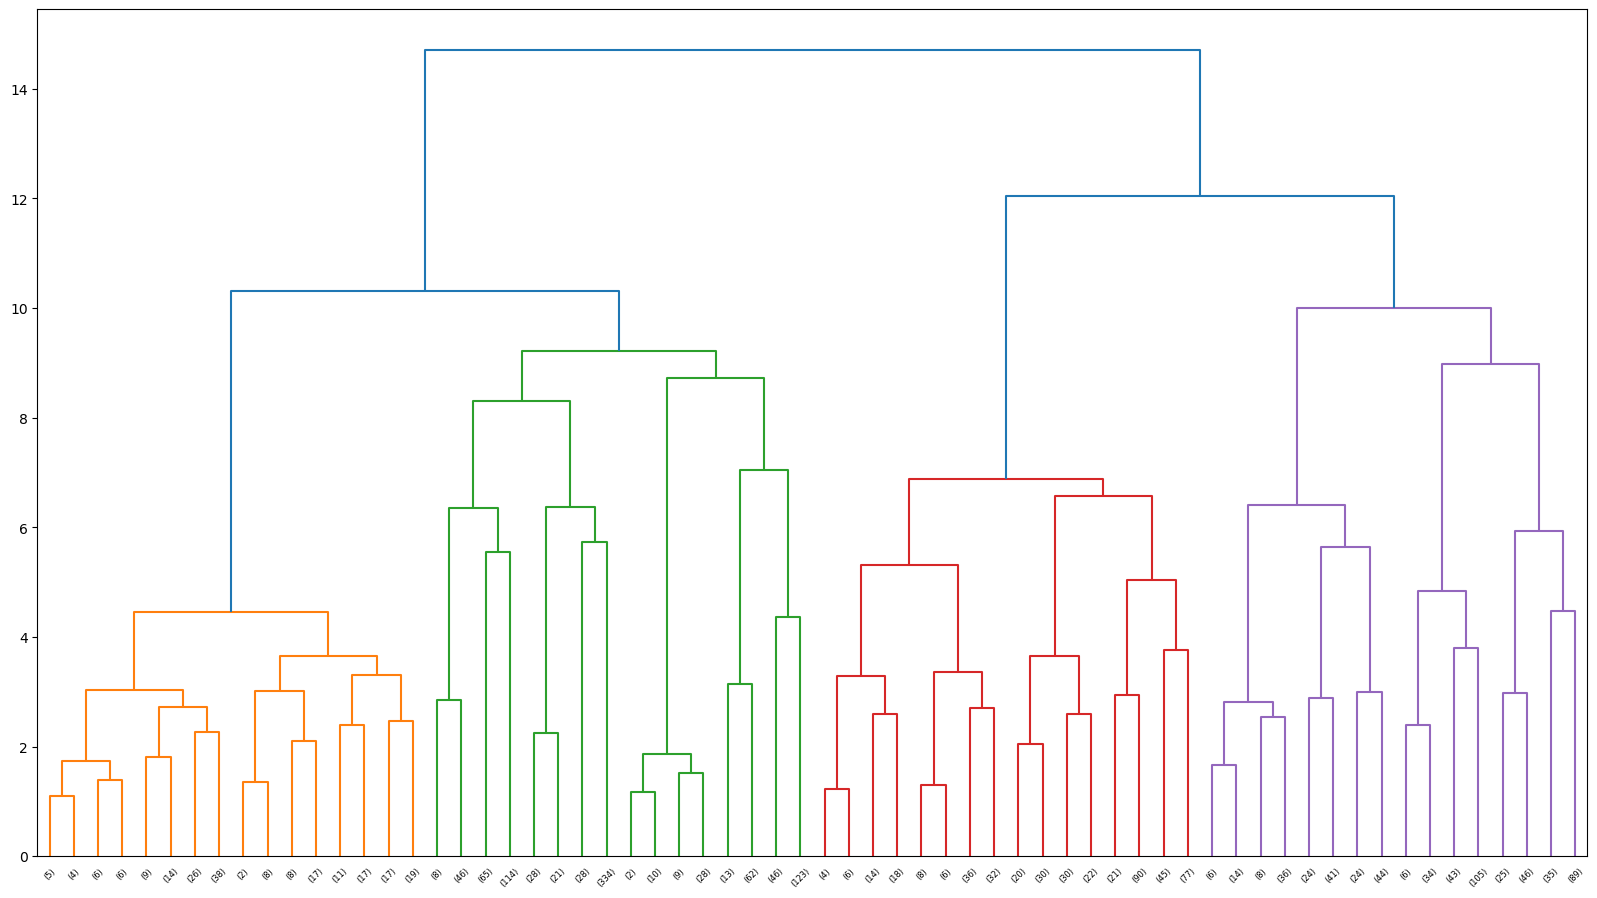

In [34]:
fig, ax = plt.subplots(1,1, figsize=(20, 11))
R = plot_dendrogram(H_clusters, ax = ax, truncate_mode = "level", p = 5, leaf_rotation = 45)
#xlabels = ax.get_xticklabels()
#ax.set_xticklabels(xlabels, ha = "right", rotation_mode = "anchor");

# other stuff

In [24]:
Z = create_linkage_matrix(hellinger_clusers)s

In [26]:
dist = pdist(abund_hellinger.T, metric="euclidean")

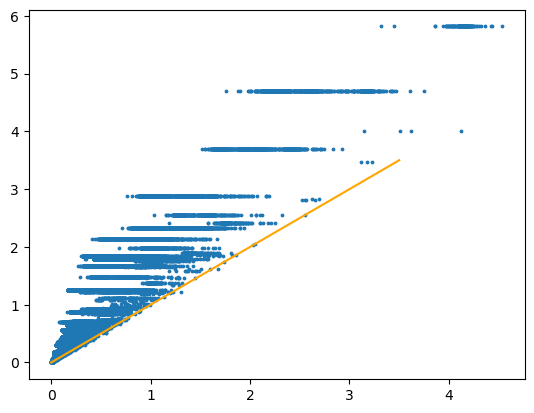

In [27]:
plt.scatter(dist, cophenet(Z), s = 3)
plt.plot(np.linspace(0,3.5, 3), np.linspace(0,3.5, 3), "orange")

In [28]:
stats.spearmanr(dist, cophenet(Z))

SignificanceResult(statistic=0.9340608582709521, pvalue=0.0)

In [7]:
scaler = StandardScaler()

In [8]:
data_scaled = scaler.fit_transform(abund_hellinger.T)

In [9]:
pca = decomposition.PCA()
pca.fit(data_scaled)

PCA()

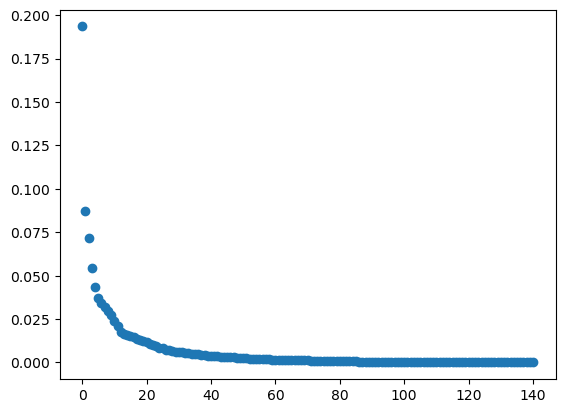

In [10]:
plt.scatter(np.arange(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)

In [11]:
np.sum(pca.explained_variance_ratio_[:5])

0.45039337428847803

In [59]:
ldngs = pca.components_.shape

(141, 141)

In [80]:
pca.components_.shape

(141, 141)

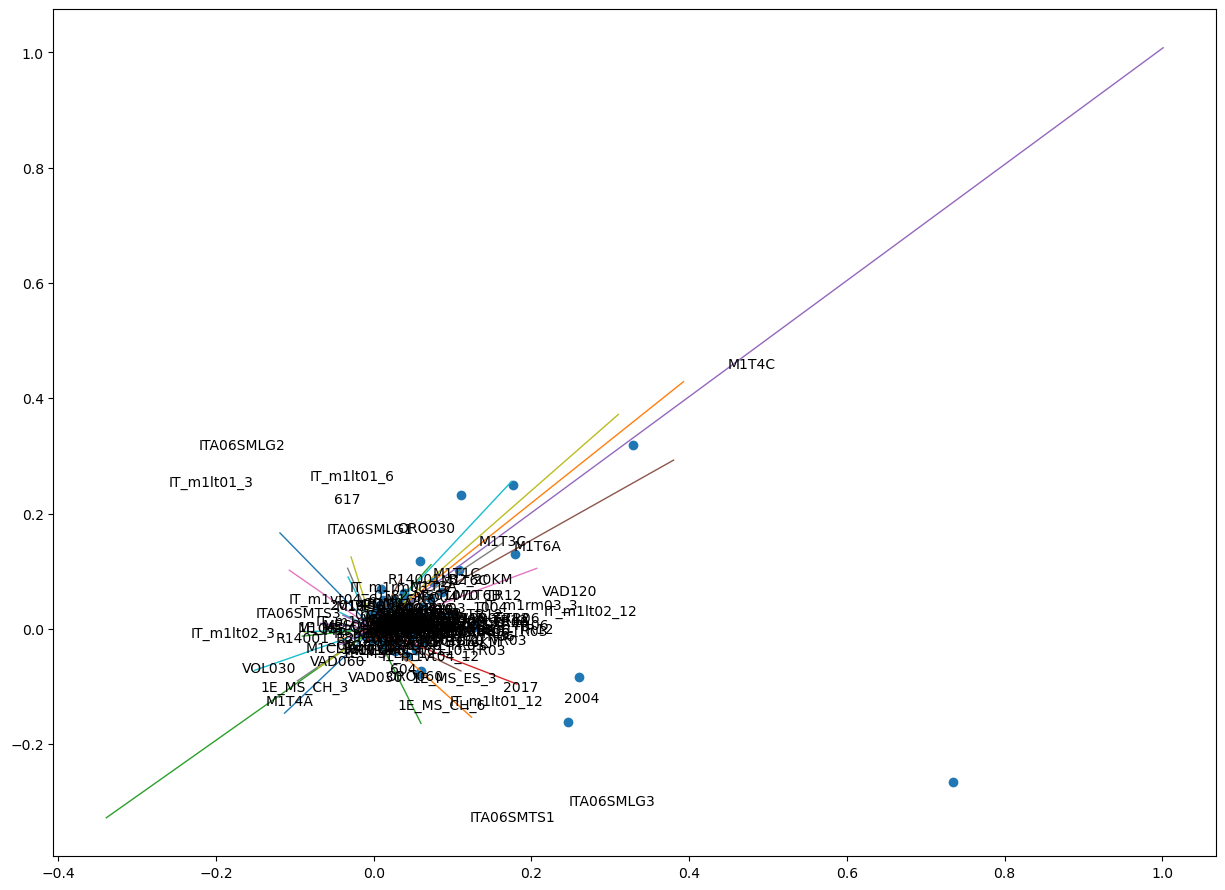

In [13]:
fig, ax = plt.subplots(1,1, figsize=(15, 11))
transformed = pca.transform(data_scaled)
X = transformed[:, 0] / (max(transformed[:, 0]) - min(transformed[:, 1]))
Y = transformed[:, 1]  / (max(transformed[:, 0]) - min(transformed[:, 1]))
plt.scatter(X,Y)
for  station, pos in zip(abund_hellinger.index.get_level_values(1).to_list(), pca.components_):
    ax.annotate(station, (pos[0], pos[1]))
    
for i, (comp, var) in enumerate(zip(pca.components_, pca.explained_variance_)):
    comp = comp *var # scale component by its variance explanation power
    plt.plot(
        [0, comp[0]],
        [0, comp[1]],
        label=f"Component {i}",
        linewidth=1,
    )

Cluster with spearman

In [23]:
spear = abund.corr("spearman")

In [24]:
S_clusters = AgglomerativeClustering(n_clusters = 10, metric = "precomputed", linkage = "average", compute_distances = True)

In [25]:
spear_clusters = S_clusters.fit(spear.apply(lambda x: np.sqrt(1 - x)).to_numpy())

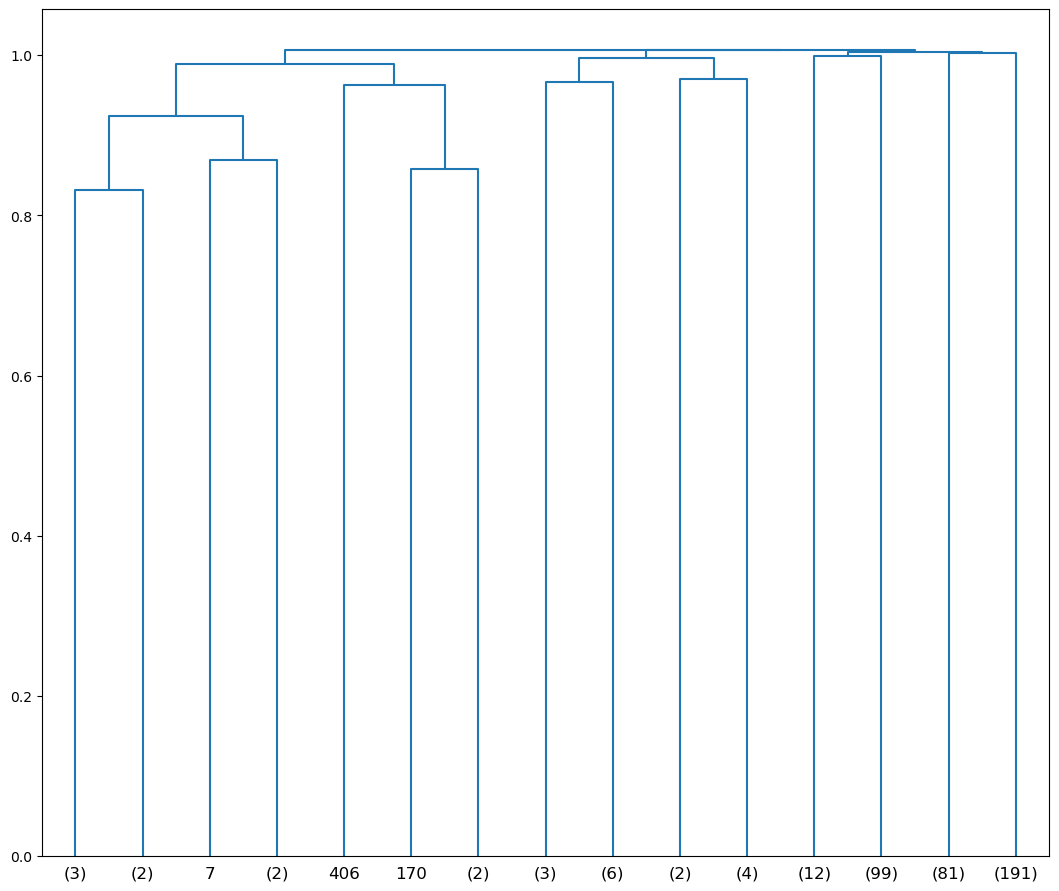

In [28]:
fig, ax = plt.subplots(1,1, figsize=(13, 11))
plot_dendrogram(spear_clusters, ax = ax, truncate_mode = "level", p = 3)

In [31]:
Z = create_linkage_matrix(spear_clusters)
dist = pdist(np.sqrt(1 - spear))

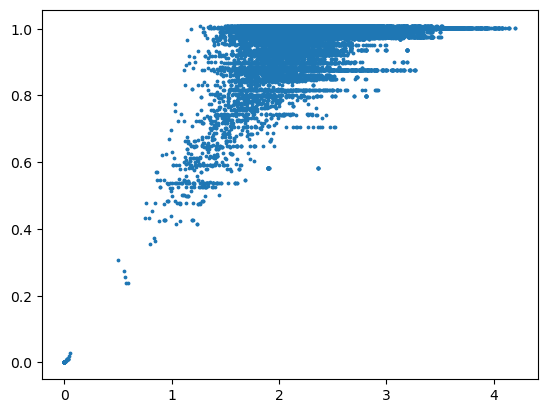

In [32]:
plt.scatter(dist, cophenet(Z), s = 3)
#plt.plot(np.linspace(0,3.5, 3), np.linspace(0,3.5, 3), "orange")

check species have been observed only once 

In [13]:
col_1_obs = np.where(abund.apply(lambda x: sum(x.astype(bool))) == 1)[0]
rows_with_obs = np.where(
    ~(abund.iloc[:, col_1_obs]==0).all(axis = 1)
)[0]

In [17]:
abund.iloc[rows_with_obs, col_1_obs].apply(lambda x: sum(x.astype(bool)), axis = 1).sort_values()

Calabria               M1T1A          1
Lazio                  IT_m1vt04_3    1
Liguria                MES120         1
                       VAD060         1
                       VOL030         1
                                     ..
Calabria               M1T3A          3
Puglia                 6CB02bis       3
Friuli-Venezia-Giulia  ITA06SMTS2     3
Emilia-Romagna         604            3
Puglia                 1CA03          4
Length: 68, dtype: int64

apply cluster to standardized values

In [14]:
log_trans = abund_hellinger.apply(lambda x: np.log(x + 1))

In [15]:
log_trans = log_trans.apply(lambda x: x / np.max(x), axis = 1)

In [11]:
H_clusters = AgglomerativeClustering(n_clusters = 10, metric = "euclidean", linkage = "ward", compute_distances = True)

In [12]:
clusters = H_clusters.fit(log_trans.to_numpy().T) 

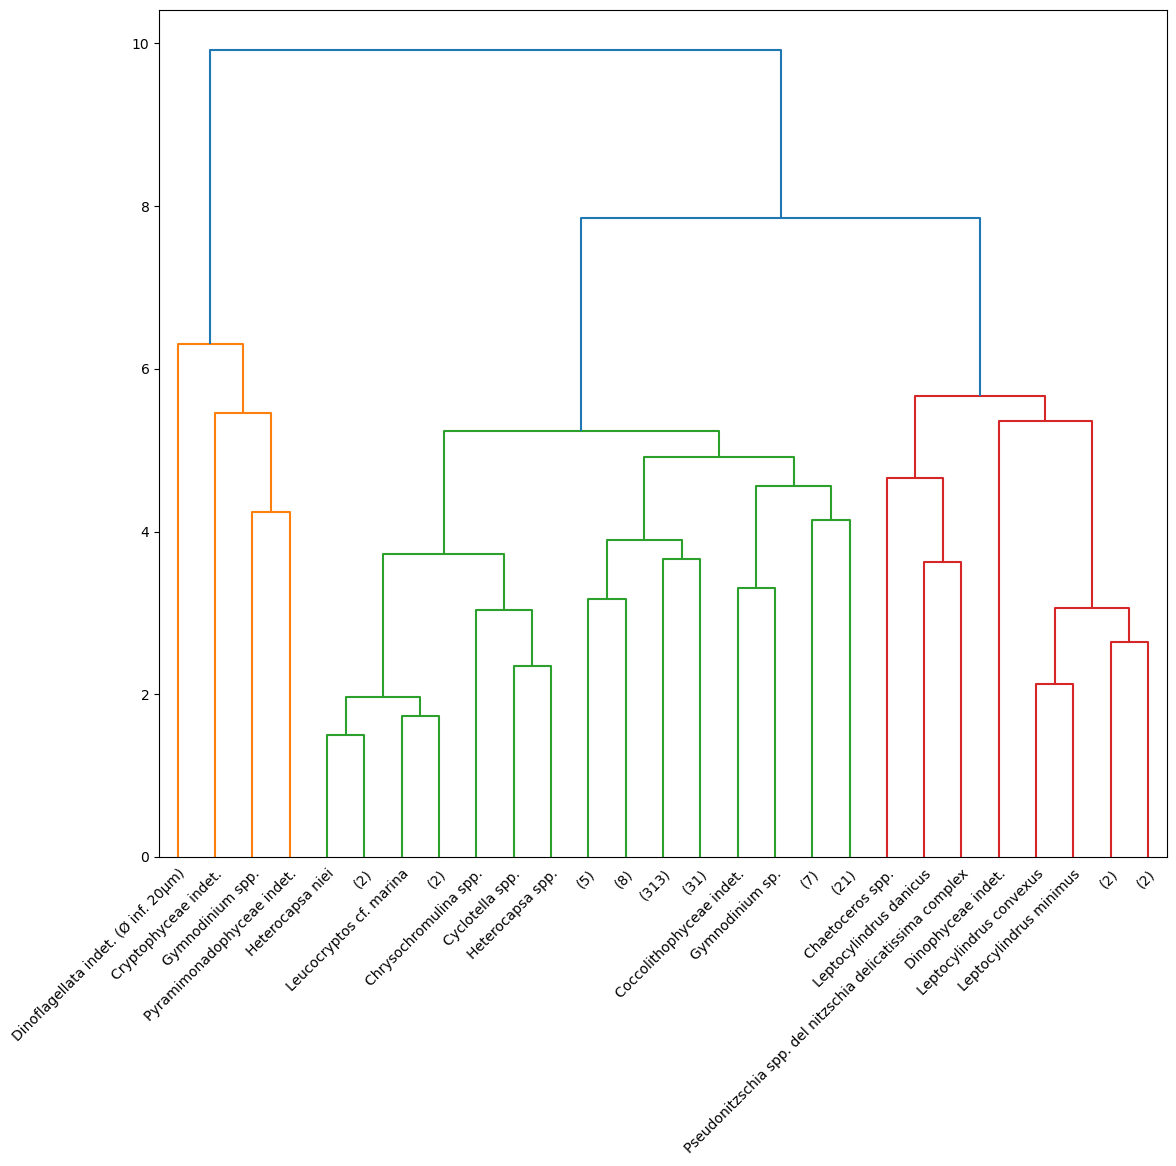

In [19]:
fig, ax = plt.subplots(1,1, figsize=(13, 11))
R = plot_dendrogram(clusters, ax = ax, truncate_mode = "level", p = 5, labels = species_list, leaf_rotation = 45)
xlabels = ax.get_xticklabels()
ax.set_xticklabels(xlabels, ha = "right", rotation_mode = "anchor");

In [38]:
abund.loc[:, ['Leptocylindrus convexus', 'Leptocylindrus minimus']].corr("spearman")

,Leptocylindrus convexus,Leptocylindrus minimus
Leptocylindrus convexus,1.000000,0.326337
Leptocylindrus minimus,0.326337,1.000000


In [ ]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(log_trans.T)

In [17]:
pca = decomposition.PCA()
pca.fit(log_trans.T)

PCA()

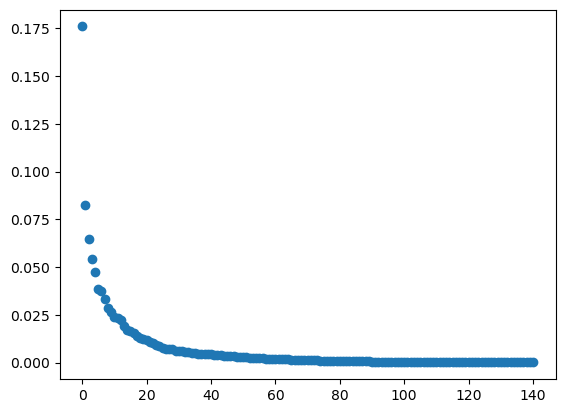

In [18]:
plt.scatter(np.arange(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)

In [19]:
pca.explained_variance_ratio_[:5]

array([0.17597175, 0.08255698, 0.0649109 , 0.05404601, 0.04760553])

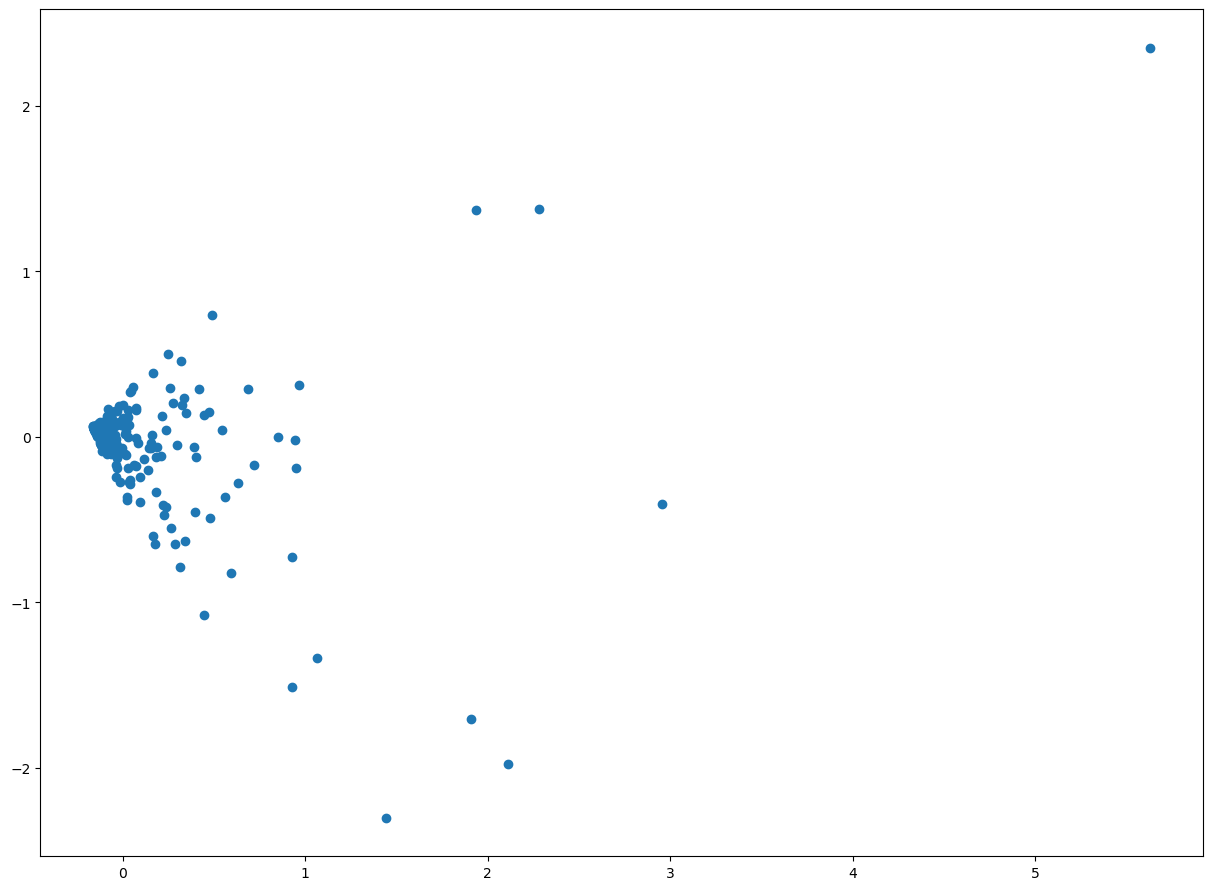

In [20]:
fig, ax = plt.subplots(1,1, figsize=(15, 11))
plt.scatter(*pca.transform(log_trans.T)[:, [0,1]].T)

kernelPCA

In [22]:
from sklearn.decomposition import KernelPCA

In [23]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(abund_hellinger.T)

In [70]:
for param in [10**(-i) for i in range(8)]:
    model = KernelPCA(kernel="rbf", gamma=param)
    model.fit(data_scaled)
    print(sum(model.eigenvalues_[:2]) / sum(model.eigenvalues_))

0.12377725108298626
0.22573719543526374
0.27402514025036967
0.24322606031297542
0.2553058618369229
0.27718918790598296
0.28024205337456287
0.2805584118551418


In [73]:
model = KernelPCA(kernel="rbf", gamma=10**(-7))
model.fit(data_scaled)

KernelPCA(gamma=1e-07, kernel='rbf')

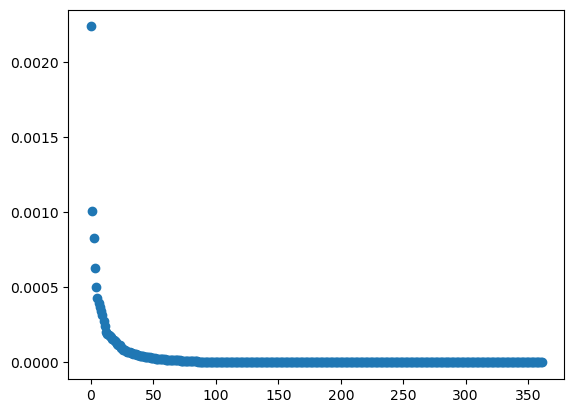

In [74]:
plt.scatter(range(len(model.eigenvalues_)), model.eigenvalues_)

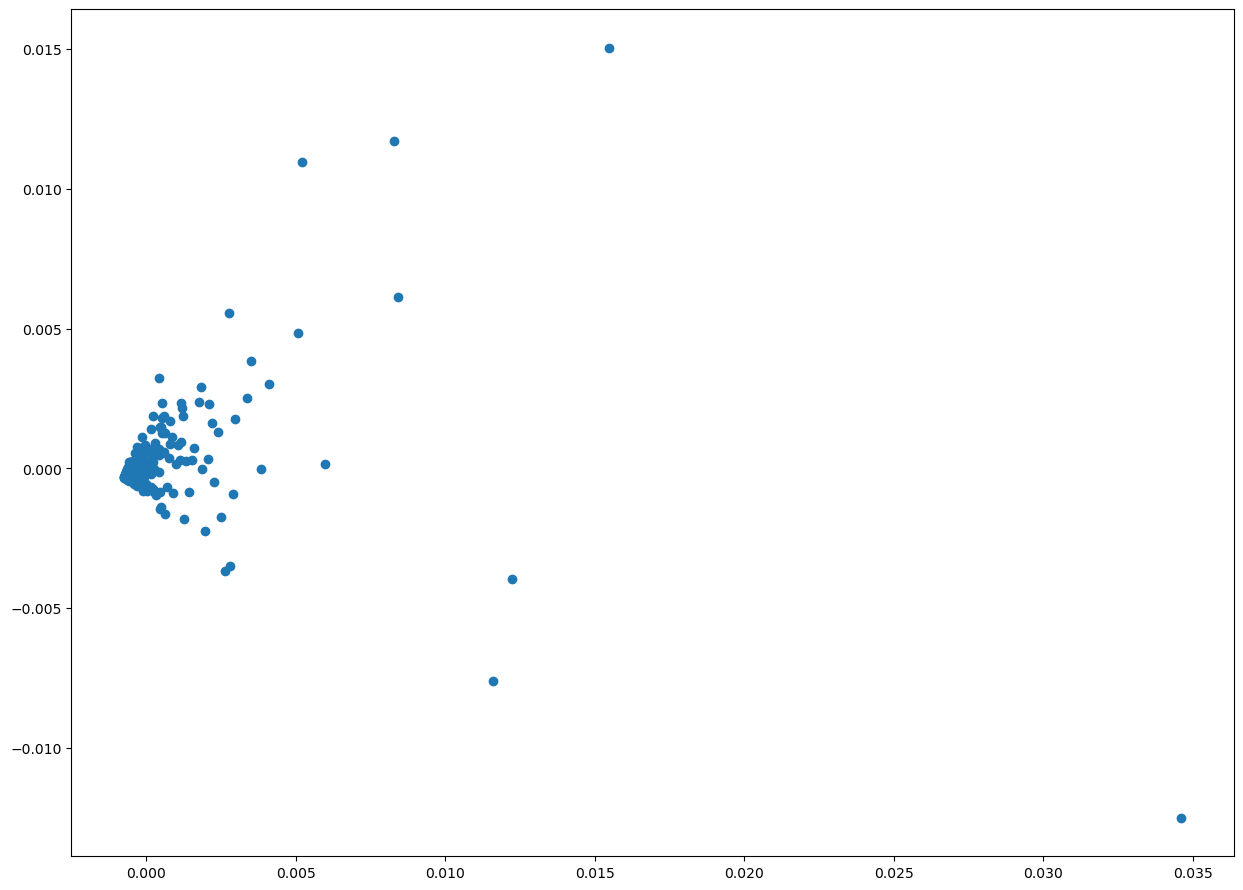

In [75]:
fig, ax = plt.subplots(1,1, figsize=(15, 11))
plt.scatter(*model.transform(data_scaled)[:, [0,1]].T)

Trying graph theory

In [6]:
import networkx as nx

In [7]:
species = abund.columns
n_species = len(species)
n_cooccur = np.zeros((n_species, n_species), dtype=int)

In [8]:
bool_species = abund.astype(bool).to_numpy()

In [9]:
for i in range(n_species): 
    for j in range(i + 1, n_species):
        n_cooccur[i,j] = np.sum(np.logical_and(bool_species[:, i], bool_species[:, j]))

In [10]:
G = nx.from_numpy_array(n_cooccur)

In [11]:
G_sub = G.subgraph(list(set(item for t in list(G.edges()) for item in t)))

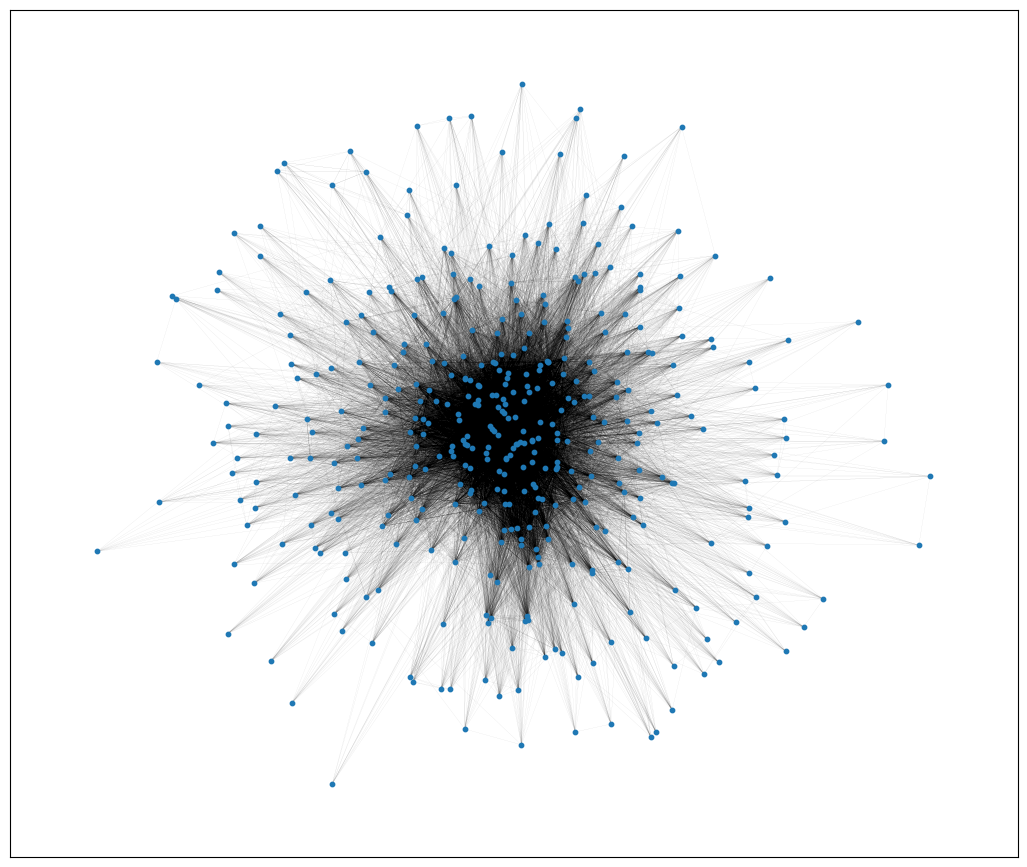

In [12]:
weight = np.array([d["weight"] for (_,_, d) in G_sub.edges(data = True)])
weight = weight / max(weight)
fig, ax = plt.subplots(1,1, figsize=(13, 11))
pos = nx.spring_layout(G_sub)
nx.draw_networkx_nodes(G_sub, ax = ax, pos = pos, node_size = 10)
nx.draw_networkx_edges(G_sub, ax = ax, pos = pos, width=weight)

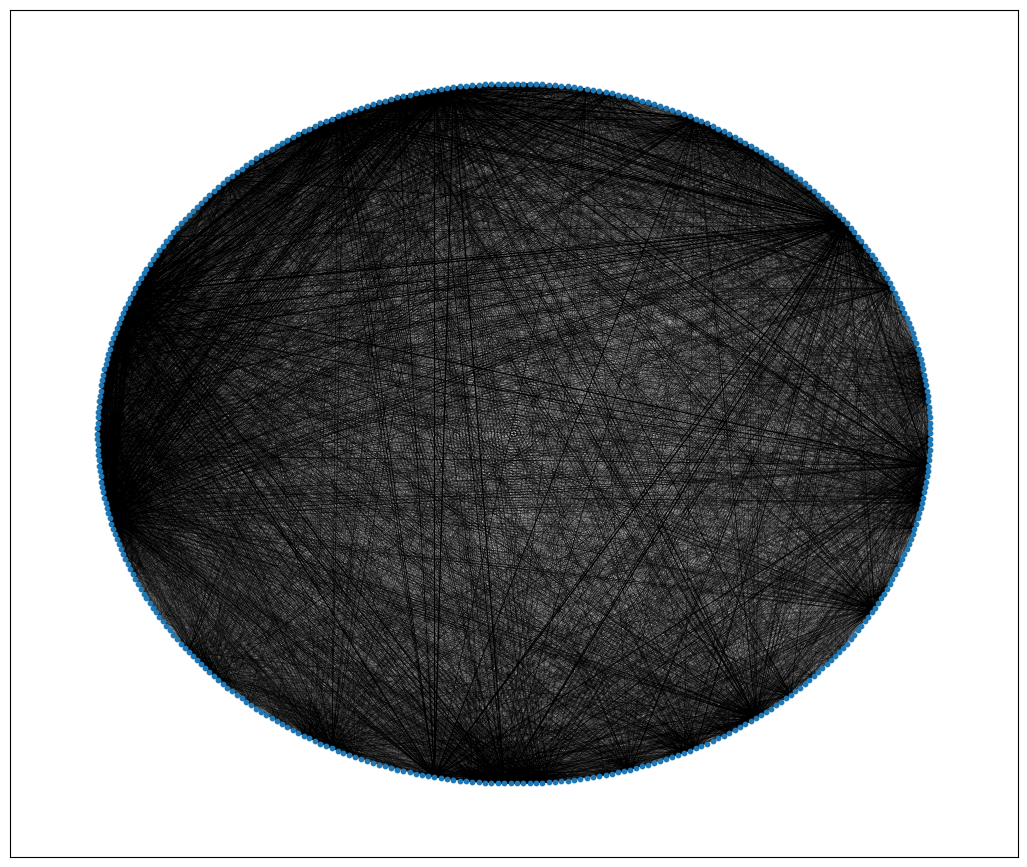

In [13]:
fig, ax = plt.subplots(1,1, figsize=(13, 11))
pos = nx.circular_layout(G_sub)
nx.draw_networkx_nodes(G_sub, ax = ax, pos = pos, node_size = 10)
nx.draw_networkx_edges(G_sub, ax = ax, pos = pos, width=weight)

## Group genera

In [157]:
col_to_group = ["Region", "id", "Longitude", "Latitude", "Date", "Sample_depth", "Genus"]

In [183]:
phyto_abund_simplified.loc[:, "Taxon"] = phyto_abund_simplified.loc[:, "Taxon"].str.replace("sp\.|cf.\s.*", "spp.", regex = True)
phyto_abund_simplified.loc[:, "Taxon"] = phyto_abund_simplified.loc[:, "Taxon"].str.replace("Bacillariophyceae.*", "Diatomee indet.", regex = True)
phyto_abund_simplified.loc[:, "Taxon"] = phyto_abund_simplified.loc[:, "Taxon"].str.replace("Bacillariophyta.*", "Diatomee indet.", regex = True)
phyto_abund_simplified.loc[:, "Taxon"] = phyto_abund_simplified.loc[:, "Taxon"].str.replace("Chlorodendrophyceae.*", "Chlorophyta indet.", regex = True)
phyto_abund_simplified.loc[:, "Taxon"] = phyto_abund_simplified.loc[:, "Taxon"].str.replace("Chlorophyceae.*", "Chlorophyta indet.", regex = True)
phyto_abund_simplified.loc[:, "Taxon"] = phyto_abund_simplified.loc[:, "Taxon"].str.replace("Chroococcales indet.", "Cyanophyceae indet.", regex = False)
phyto_abund_simplified.loc[:, "Taxon"] = phyto_abund_simplified.loc[:, "Taxon"].str.replace("Chrysophyceae.*", "Chrysophyceae indet.", regex = True)
phyto_abund_simplified.loc[:, "Taxon"] = phyto_abund_simplified.loc[:, "Taxon"].str.replace("Coccolithophyceae.*", "Coccolithophyceae indet.", regex = True)
phyto_abund_simplified.loc[:, "Taxon"] = phyto_abund_simplified.loc[:, "Taxon"].str.replace("Dinophyceae indet. (ø inf. 20µm)", "Dinoflagellata indet. (Ø inf. 20µm)", regex = False)
phyto_abund_simplified.loc[:, "Taxon"] = phyto_abund_simplified.loc[:, "Taxon"].str.replace("Dinophyceae indet. (ø sup. 20µm)", "Dinoflagellata indet. (Ø sup. 20µm)", regex = False)
phyto_abund_simplified.loc[:, "Taxon"] = phyto_abund_simplified.loc[:, "Taxon"].str.replace("Noctilucea indet.", "Dinoflagellata indet.", regex = False)
phyto_abund_simplified.loc[:, "Taxon"] = phyto_abund_simplified.loc[:, "Taxon"].str.replace("Euglenophyceae.*", "Euglenophyceae indet.", regex = True)
phyto_abund_simplified.loc[:, "Taxon"] = phyto_abund_simplified.loc[:, "Taxon"].str.replace("Gymnodiniaceae.*|Gymnodiniales.*", "Gymnodiniales indet.", regex = True)
phyto_abund_simplified.loc[:, "Taxon"] = phyto_abund_simplified.loc[:, "Taxon"].str.replace("Naviculaceae indet.", "Diatomee indet.", regex = False)
phyto_abund_simplified.loc[:, "Taxon"] = phyto_abund_simplified.loc[:, "Taxon"].str.replace("Oscillatoriales indet.", "Cyanophyceae indet.", regex = False)
phyto_abund_simplified.loc[:, "Taxon"] = phyto_abund_simplified.loc[:, "Taxon"].str.replace("Pedinellales indet.", "Cyanophyceae indet.", regex = False)
phyto_abund_simplified.loc[:, "Taxon"] = phyto_abund_simplified.loc[:, "Taxon"].str.replace("Peridiniales.*", "Peridiniales indet.", regex = True)

In [184]:
phyto_abund_simplified = phyto_abund_simplified.groupby(col_to_group + ["Taxon"]).sum().reset_index()

In [193]:
relative_abund = None
dates = phyto_abund_simplified["Date"].between(datetime.datetime(2017,5,1), datetime.datetime(2017,5,31))
for (region_name, df_region) in phyto_abund_simplified.loc[dates, ["Region", "id", "Date", "Taxon", "Num_cell_l"]].groupby("Region"): 
    relative_abund_reg = find_most_representative_species(df_region.drop(columns="Region"), groupby_columns= ["id", "Date"], taxon_column="Taxon",  numeric_column = "Num_cell_l", threshold=1.1, relative_abundance=False)
    relative_abund_reg.reset_index(level = "Taxon", inplace=True)
    relative_abund_reg = relative_abund_reg[~relative_abund_reg["Taxon"].str.contains("Other")]
    relative_abund_reg = pd.pivot_table(relative_abund_reg, index= "id", columns = "Taxon", values="Num_cell_l").fillna(0).T
    relative_abund_reg.columns = pd.MultiIndex.from_tuples((region_name, station_id) for station_id in relative_abund_reg.columns)
    if relative_abund is None: 
        relative_abund = relative_abund_reg
    else: 
        relative_abund = pd.merge(left=relative_abund, right=relative_abund_reg, how = "outer", left_index=True, right_index=True)
relative_abund.fillna(0,inplace=True)
del relative_abund_reg

In [194]:
relative_abund

Abruzzo                       Basilicata  \
                        1_ABR_VA13 1_ABR_VA14 1_ABR_VA15 M1_SINNI_1   
Taxon                                                                 
Acanthoica quattrospina        0.0        0.0        0.0       0.00   
Achradina pulchra              0.0        0.0        0.0       0.00   
Achradina spp.                 0.0        0.0        0.0       0.00   
Akashiwo sanguinea             0.0        0.0        0.0       0.00   
Alexandrium insuetum           0.0        0.0        0.0       0.00   
...                            ...        ...        ...        ...   
Torodinium robustum            0.0        0.0        0.0    2551.25   
Torodinium spp.                0.0        0.0        0.0       0.00   
Torodinium teredo              0.0        0.0        0.0       0.00   
Trachelomonas spp.             0.0        0.0        0.0       0.00   
Vicicitus globosus             0.0        0.0        0.0       0.00   

                                                  Calabria                     \
                          M1_SINNI_2   M1_SINNI_3    M1T1A  M1T1B M1T1C M1T3A   
Taxon                                                                           
Acanthoica quattrospina     0.000000     0.000000      0.0    0.0   0.0   0.0   
Achradina pulchra           0.000000     0.000000      0.0    0.0   0.0   0.0   
Achradina spp.              0.000000     0.000000      0.0    0.0   0.0   0.0   
Akashiwo sanguinea          0.000000     0.000000      0.0    0.0   0.0   0.0   
Alexandrium insuetum        0.000000     0.000000      0.0    0.0   0.0   0.0   
...                              ...          ...      ...    ...   ...   ...   
Torodinium robustum      3280.178571  4009.107143      0.0  120.0  60.0   0.0   
Torodinium spp.             0.000000     0.000000      0.0    0.0   0.0   0.0   
Torodinium teredo           0.000000     0.000000      0.0    0.0   0.0   0.0   
Trachelomonas spp.          0.000000     0.000000      0.0    0.0   0.0   0.0   
Vicicitus globosus          0.000000     0.000000      0.0    0.0   0.0   0.0   

                         ...     Toscana                                      \
                         ... SMR_CCE_WA5 SMR_CPI_WA1 SMR_CPI_WA3 SMR_CPI_WA5   
Taxon                    ...                                                   
Acanthoica quattrospina  ...        83.0        38.0         0.0         0.0   
Achradina pulchra        ...         0.0         0.0         0.0         0.0   
Achradina spp.           ...         0.0         0.0         0.0         0.0   
Akashiwo sanguinea       ...         0.0         0.0         0.0         0.0   
Alexandrium insuetum     ...         0.0         0.0         0.0         0.0   
...                      ...         ...         ...         ...         ...   
Torodinium robustum      ...       104.0       345.0       103.0         0.0   
Torodinium spp.          ...         0.0         0.0         0.0         0.0   
Torodinium teredo        ...         0.0         0.0         0.0         0.0   
Trachelomonas spp.       ...         0.0         0.0         0.0         0.0   
Vicicitus globosus       ...         0.0         0.0         0.0         0.0   

                         Veneto                                
                          50530 50720 60530 60720 70530 70720  
Taxon                                                          
Acanthoica quattrospina     0.0   0.0   0.0   0.0   0.0   0.0  
Achradina pulchra           0.0   0.0   0.0   0.0   0.0   0.0  
Achradina spp.              0.0   0.0   0.0   0.0   0.0   0.0  
Akashiwo sanguinea          0.0   0.0   0.0   0.0   0.0   0.0  
Alexandrium insuetum        0.0   0.0   0.0   0.0   0.0   0.0  
...                         ...   ...   ...   ...   ...   ...  
Torodinium robustum      2268.0   0.0   0.0   0.0   0.0   0.0  
Torodinium spp.             0.0   0.0   0.0   0.0   0.0   0.0  
Torodinium teredo           0.0   0.0   0.0   0.0   0.0   0.0  
Trachelo

In [202]:
frequencies = phyto_abund_simplified.loc[:, ["Taxon", "Num_cell_l"]].groupby("Taxon").count().rename(columns={"Num_cell_l": "Freq"}).reset_index().sort_values(by = "Freq", ascending=False)

<Axes: xlabel='Freq', ylabel='Probability'>

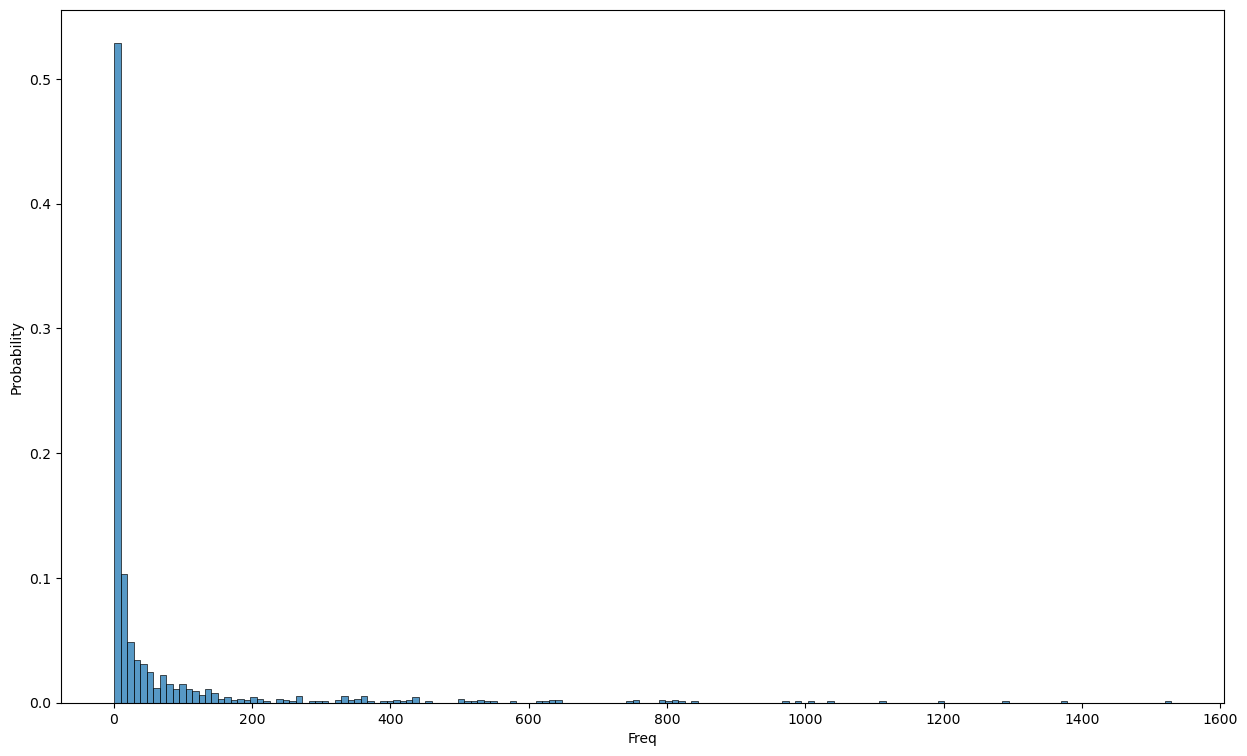

In [207]:
fig, ax = plt.subplots(1,1, figsize = (15,9))
sns.histplot(frequencies, x = "Freq", ax = ax, stat="probability")